# Qubit Tune-up with SHF Instruments

In this notebook we demonstrate qubit tuneup with the LabOne Q software, implemented as a sequence of experiments. 

Before starting the experiments, we define a set of initial qubit parameters, as might be known from fabrication. 

These parameters can then be used to update the baseline calibration used in the experiments.

## 0. General Imports and Definitions
### 0.1 Python Imports 

In [1]:
# LabOne Q:
from laboneq.simple import *

# plotting and fitting functionality
from laboneq.analysis.fitting import (
    lorentzian,
    oscillatory,
    oscillatory_decay,
    exponential_decay,
)
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

# descriptor imports
from laboneq.contrib.example_helpers.descriptors.shfsg_shfqa_pqsc import (
    descriptor_shfsg_shfqa_pqsc,
)

# for saving results and pulse sheets
from pathlib import Path
import time

import matplotlib.pyplot as plt
import numpy as np
import resonator_fitting as res_fit

# DC source (yoko) from GPIB/LAN

In [1]:
from qcodes.instrument_drivers.yokogawa.GS200 import GS200

In [3]:
# dc2 = GS200('yoko', 'GPIB0::15::INSTR')
dc = GS200('yoko', address = 'TCPIP0::192.168.3.193::inst0::INSTR')

Connected to: YOKOGAWA GS210 (serial:91N522620, firmware:2.02) in 0.40s


In [4]:
# dc.close()
dc.source_mode('CURR')

In [5]:
# dc.output('on')
dc.ramp_current(0e-3, 1e-5,0)

### 0.2 Function Definitions

In [7]:
# define sweep parameter
def create_readout_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"res_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        stop=stop_freq + qubit.parameters.readout_resonator_frequency - qubit.parameters.readout_lo_frequency,
        count=num_points,
    )

# function that returns the calibration of the readout line oscillator for spectroscopy
def res_spec_calib(frequency_sweep, amplitude_sweep=None):
    exp_calibration = Calibration()
    # sets the oscillator of the experimental measure signal
    exp_calibration["measure"] = SignalCalibration(
        # for spectroscopy, use the hardware oscillator of the QA, and set the sweep parameter as frequency
        oscillator=Oscillator(
            "readout_osc",
            frequency=frequency_sweep,
            modulation_type=ModulationType.HARDWARE,
        ),
        amplitude=amplitude_sweep,
    )
    return exp_calibration


# signal maps for the qubit readout only
def res_spec_map(qubit):
    signal_map = {
        "measure": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[qubit.uid].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

# create gaussian square pulse for readout
def create_readout_pulse(
    qubit, sigma=0.2
):
    readout_pulse = pulse_library.gaussian_square(
        uid=f"readout_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined['readout_len'],
        amplitude=qubit.parameters.user_defined['readout_amp'],
        width=qubit.parameters.user_defined['readout_len'] * 0.9,
        sigma=sigma,
    )
    return readout_pulse

# qubit spectroscopy freq sweep
def create_drive_freq_sweep(qubit, start_freq, stop_freq, num_points):
    return LinearSweepParameter(
        uid=f"drive_freq_{qubit.uid}",
        start=start_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        stop=stop_freq + qubit.parameters.resonance_frequency_ge - qubit.parameters.drive_lo_frequency,
        count=num_points,
    )

# define square pulse for qubit spec
def create_drive_spec_pulse(qubit, amp = 0.95):
    pulse = pulse_library.const(
        uid=f"drive_spec_pulse_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=amp, #max power to start
    )
    return pulse

# signal map for qubit drive and readout
def signal_map_default(qubit):
    signal_map = {
        "drive": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "drive_line"
        ],
        "measure": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "measure_line"
        ],
        "acquire": device_setup.logical_signal_groups[f"{qubit.uid}"].logical_signals[
            "acquire_line"
        ],
    }
    return signal_map

#define gaussian pulse for qubit drive
def create_rabi_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined["pulse_length"],
        amplitude=1,
    )

# define qubit drive rabi sweep
def create_rabi_amp_sweep(qubit, amp_num, uid="rabi_amp"):
    amp_min = 0.001
    amp_max = 1#min([qubit.parameters.user_defined['amplitude_pi'] * 2.2, 1.0])
    return LinearSweepParameter(uid=uid, start=amp_min, stop=amp_max, count=amp_num)

# def create_rabi_time_sweep(qubit, t_num, start, stop, uid="rabi_time"):
#     time_min = start
#     time_max = stop
#     return LinearSweepParameter(uid=uid, start=start, stop=stop, count=t_num)

# define delay time sweep for Ramsey, T1, echo
def create_delay_sweep(
    start=0, stop=50e-6, count=100, axis_name="Time [s]"
):
    time_sweep = LinearSweepParameter(
        uid="time_sweep_param", start=start, stop=stop, count=count, axis_name=axis_name
    )
    return time_sweep

# define ramsey drive pulse
def create_ramsey_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'] / 2,
    )

# define T1 drive pulse
def create_T1_drive_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

def create_pi_2_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_2_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi']/2,
    )

def create_pi_pulse(qubit):
    return pulse_library.gaussian(
        uid=f"gaussian_pi_drive_{qubit.uid}",
        length=qubit.parameters.user_defined['pulse_length'],
        amplitude=qubit.parameters.user_defined['amplitude_pi'],
    )

## 1. Define the Instrument Setup and Required Experimental Parameters
### 1.1 Create device setup

Create the device setup from the descriptor, and apply some convenient mapping to instruments and logical signals.

In [8]:
descriptor_shfqc = """
instruments:
  SHFQC:
  - address: DEV12237
    uid: device_shfqc
    interface: 1gbe

connections:
  device_shfqc:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT

    - iq_signal: q0/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q0/acquire_line
      ports: [QACHANNELS/0/INPUT]

    - iq_signal: q1/drive_line
      ports: SGCHANNELS/2/OUTPUT

    - iq_signal: q1/measure_line
      ports: [QACHANNELS/0/OUTPUT]
    - acquire_signal: q1/acquire_line
      ports: [QACHANNELS/0/INPUT]
"""

In [9]:
# Define and Load our Device Setup
device_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor_shfqc,
    server_host="localhost",  # ip address of the LabOne dataserver used to communicate with the instruments
    server_port="8004",  # port number of the dataserver - default is 8004
    setup_name="my_setup",  # setup name
)

# define shortcut to logical signals for convenience
lsg = {
    qubit_name: device_setup.logical_signal_groups[qubit_name].logical_signals
    for qubit_name in device_setup.logical_signal_groups.keys()
}

### 1.2 Qubit Parameters

A python dictionary containing all parameters needed to control and readout the qubits - frequencies, pulse lengths, timings

May initially contain only the design parameters and will be updated with measurement results during the tuneup procedure

In [10]:
q0 = Transmon.from_logical_signal_group(
    "q0",
    lsg=device_setup.logical_signal_groups["q0"],
    parameters=TransmonParameters(
        resonance_frequency_ge=3.15e9,     #Drive frequency for qubit ge transition
        resonance_frequency_ef=2.95e9,     #Drive frequency for qubit ef transtion
        drive_lo_frequency=6.1e9,          #Center frequency for qubit drive, needs to be within 500 MHz of both ge and ef frequencies
        readout_resonator_frequency=7002311900.0, #Readout frequency for readout resonator
        readout_lo_frequency=7.0e9,        #Center frequency for readout line, shared node, all qubits need to have the same value
        readout_integration_delay=0,       #Propogation delay for readout aqcuire line, relative to default 212 ns, shared node, all qubits need to have the same value
        drive_range = 10,                  #Output range for qubit drive in dBm
        readout_range_out = 20,             #Output range for readout resonator in dBm, shared node, all qubits need to have the same value
        readout_range_in = 0,              #Input range for readout resonator in dBm, shared node, all qubits need to have the same value
        
        user_defined={                     #Pulse Parameters to be included as user_defined
            "amplitude_pi": 0.5,           #Amplitude of Pi pulse, linear gain from 0 to 1 of drive_range
            "pulse_length": 50e-9,         #Length of drive/Pi pulse
            "readout_len": 2e-6,           #Length of readout pulse
            "readout_amp": 0.98,           #Amplitude of readout pulse, linear gain from 0 to 1 of readout_range_out, starts at 1 for spectroscopy
            "reset_length": 5e-6,          #Relaxation time to return to ground state
        },
    ),
)

q1 = Transmon.from_logical_signal_group(
    "q1",
    lsg=device_setup.logical_signal_groups["q1"],
    parameters=TransmonParameters(
        resonance_frequency_ge=6.25e9,
        resonance_frequency_ef=5.95e9,
        drive_lo_frequency=7.1e9,
        readout_resonator_frequency=7.4e9,
        readout_lo_frequency=q0.parameters.readout_lo_frequency, #Shared node, needs to match q0 center frequency
        readout_integration_delay=q0.parameters.readout_integration_delay, #Shared node, needs to match q0
        drive_range = 10,
        readout_range_out = q0.parameters.readout_range_out, #Shared node, needs to match q0
        readout_range_in = q0.parameters.readout_range_in, #Shared node, needs to match q0
        user_defined={
            "amplitude_pi": 0.6,
            "pulse_length": 50e-9,
            "readout_len": 2e-6,
            "readout_amp": 0.98,
            "reset_length": 5e-6,
        },
    ),
)

In [11]:
#Finish calibrating SHFQC with qubit parameters
qubits = [q0, q1]
for qubit in qubits:
    device_setup.set_calibration(qubit.calibration())

#Choose which qubit will be measured
measure_q = q0

### 2.2 Create and Connect to a QCCS Session 

Establishes the connection to the instruments and readies them for experiments

In [12]:
# perform experiments in emulation mode or on hardware - if True, also generate dummy data for fitting
emulate = False

# create and connect to a session
session = Session(device_setup=device_setup)
session.connect(do_emulation=emulate)

[2024.06.13 14:05:32.554] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is Z:\projects\2024-two_Kerr-Cats\laboneq_output\log
[2024.06.13 14:05:32.565] INFO    VERSION: laboneq 2.32.0
[2024.06.13 14:05:32.569] INFO    Connecting to data server at localhost:8004
[2024.06.13 14:05:32.632] INFO    Connected to Zurich Instruments LabOne Data Server version 24.04 at localhost:8004
[2024.06.13 14:05:32.650] WARNING SHFQC/QA:dev12237: Include the device options 'SHFQC/PLUS/QC6CH' in the device setup ('options' field of the 'instruments' list in the device setup descriptor). This will become a strict requirement in the future.
[2024.06.13 14:05:33.367] INFO    Configuring the device setup
[2024.06.13 14:05:33.477] INFO    The device setup is configured


## 3. Qubit Tuneup - Experimental Sequence

Sequence of experiments for tuneup from scratch of a superconducting qubit in circuit QED architecture 

### 3.1 Resonator Spectroscopy: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

In [13]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -100e6
stop_freq = 100e6
num_points = 1001
integration_time = 1e-3
num_averages = 5

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [14]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [30]:
# measure_q.parameters.readout_range_out = -20
# measure_q.parameters.readout_range_in = 0
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = 0
measure_q.parameters.user_defined['readout_amp'] = 0.5

In [31]:
measure_q.parameters.readout_lo_frequency = 7.0e9
measure_q.parameters.readout_resonator_frequency = 7.193e9
# measure_q.parameters.readout_integration_delay = 0

measure_q.parameters.user_defined['reset_length'] = 100e-6

In [32]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=7193000000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=10,
│   │   readout_range_out=-10,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.5,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [33]:
device_setup.set_calibration(measure_q.calibration())

In [38]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -20e6
stop_freq = 20e6
num_points = 1001
integration_time = 2e-3
num_averages = 2

In [39]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [40]:
exp_spec.set_signal_map(res_spec_map(measure_q))

# run the experiment on the open instrument session
compiled_res_spec = session.compile(exp_spec)
res_spec_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

[2024.06.13 14:11:55.963] INFO    Starting LabOne Q Compiler run...
[2024.06.13 14:11:56.096] INFO    Schedule completed. [0.130 s]
[2024.06.13 14:11:56.299] INFO    Code generation completed for all AWGs. [0.202 s]
[2024.06.13 14:11:56.301] INFO    Completed compilation step 1 of 1. [0.335 s]
[2024.06.13 14:11:56.304] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 14:11:56.306] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.13 14:11:56.307] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 14:11:56.307] INFO      device_shfqc     0         27            0           0         0  
[2024.06.13 14:11:56.309] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 14:11:56.310] INFO      TOTAL                      27            0                     0  
[2024.06.13 14:11:56.311] INFO     ────────────────────────────────────────────────────

Text(0.5, 0, 'Frequency (GHz)')

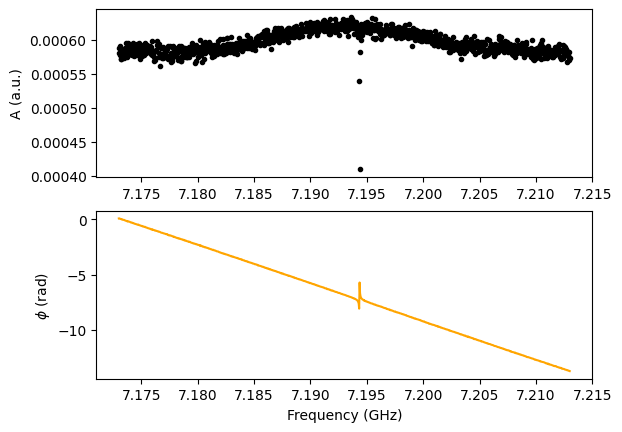

In [41]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]
%matplotlib inline
if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.unwrap(np.angle(spec_res)), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6582311900.0/1e9)

# plt.show()

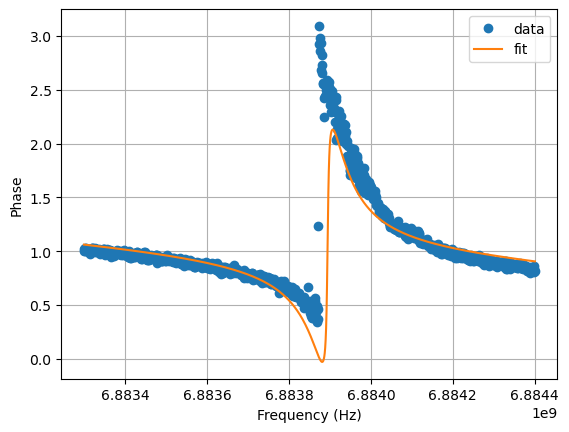

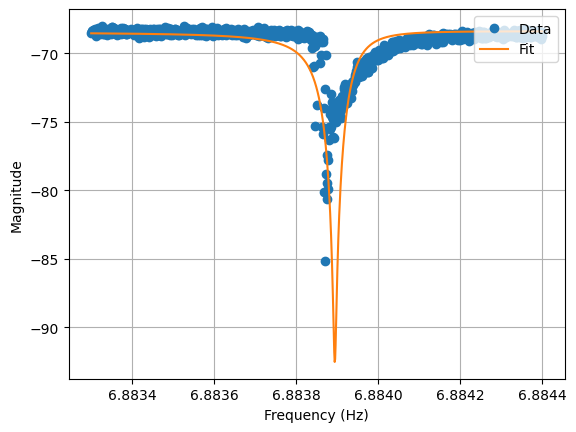

{'a': 0.0002165119680877853,
 'b': 0.00030983948327578204,
 'f0': 6883899201.556366,
 'kappa': 103492.74758497809,
 'kappa_int': 54981.81413588785,
 'kappa_ext': 48510.93344909024,
 'Q': 66515.76426554898,
 'Qe': 141904.07630025648,
 'Qi': 124653.84834654296,
 'phi': -0.09999055030007375,
 'tau': -3.028969208171257e-07,
 'a_sd': 1.492361919579846e-06,
 'b_sd': 1.6167198445365559e-06,
 'f0_sd': 787.3890228279503,
 'kappa_sd': 2590.143483339913,
 'kappa_int_sd': 1430.5668705758737,
 'Q_sd': 416.18049101179236,
 'Qi_sd': 4175.082350260704,
 'Qe_sd': 2948.7416744660973,
 'tau_sd': 1.2988450609183169e-08}

In [266]:
freqs =spec_freq 
dataComplex=spec_res
params = res_fit.resonator_regression(freqs,dataComplex)[0];
cov= res_fit.resonator_regression(freqs,dataComplex)[1];
fit_data = res_fit.resonator_f_to_S(freqs,*params)
tau=res_fit.reflection_resonator_params(*params,covar=cov)['tau']
f0=res_fit.reflection_resonator_params(*params,covar=cov)['f0']

readout_frequency = f0


# phase 
plt.plot(freqs,np.unwrap(np.angle(dataComplex)),'o', label='data')
plt.plot(freqs,np.unwrap(np.angle(fit_data)), label='fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Mag
plt.plot(freqs/1e9,20*np.log10(abs(dataComplex)), 'o',label='Data')
plt.plot(freqs/1e9,20*np.log10(abs(fit_data)), label='Fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')  
plt.grid()
plt.show()
# params

res_fit.reflection_resonator_params(*params,covar=cov)

In [259]:
(7204009941.4532795-7204011848.329579)/1e6

-0.0019068762998580933

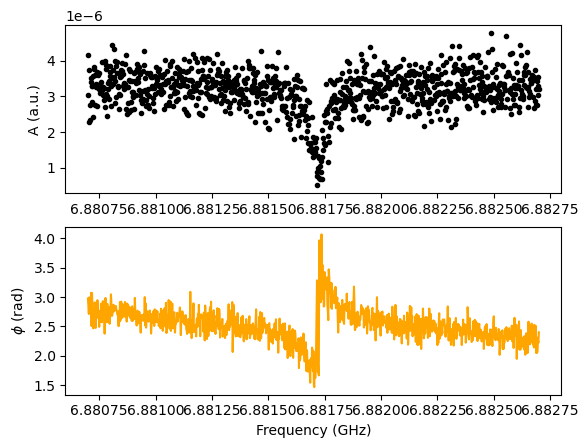

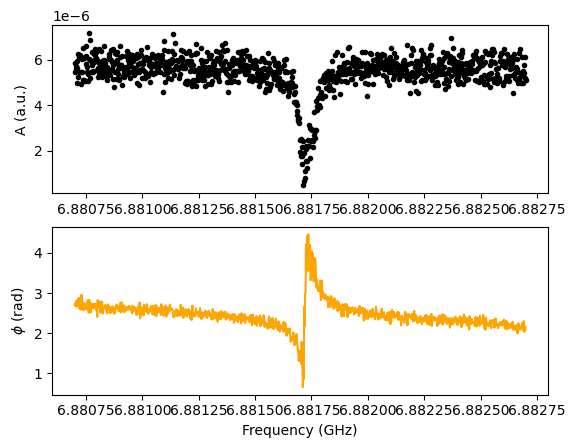

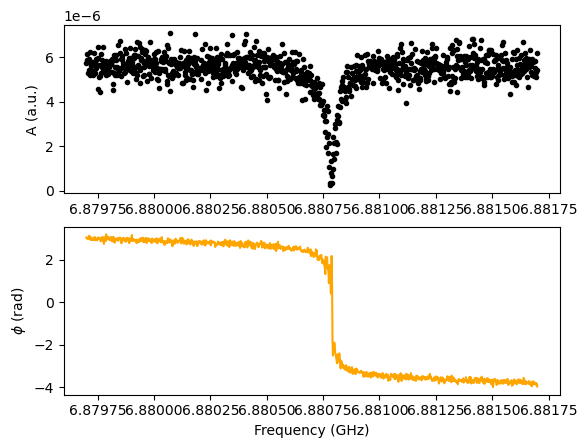

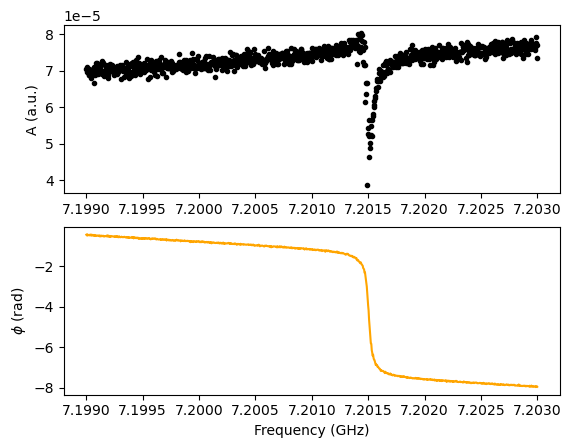

#### flux sweep resonator

In [42]:
measure_q.parameters.readout_range_out = -10
measure_q.parameters.readout_range_in = 0
# measure_q.parameters.readout_range_out = 10
# measure_q.parameters.readout_range_in = 5
# measure_q.parameters.user_defined['readout_amp'] = 0.5

In [58]:
measure_q.parameters.readout_lo_frequency = 7.0e9
measure_q.parameters.readout_resonator_frequency = 6.875e9

In [59]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=6875000000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=10,
│   │   readout_range_out=-10,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.5,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [60]:
device_setup.set_calibration(measure_q.calibration())

In [61]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -0.01e9
stop_freq = 0.01e9
num_points = 1001
integration_time = 2e-3
num_averages = 5

In [62]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [48]:
dc.current_range(0.01)

In [211]:
dc.ramp_current(0e-3, 1e-6, 0)

In [50]:
dc.ramp_current(0, 1e-6, 0)
dc.output('on')
dc.ramp_current(-10e-3, 1e-6, 0)

In [69]:
current_range = 5e-3
current_sweep = np.linspace(-current_range, 0, 101)

sweep_resonator_results = []
sweep_resonator_results_delayed = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.5)
    exp_spec.set_signal_map(res_spec_map(measure_q))

    # run the experiment on the open instrument session
    compiled_res_spec = session.compile(exp_spec)
    res_spec_results = session.run()
    
    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
    # print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")
    sweep_resonator_results.append(res_spec_results.get_data("res_spec"))
    spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]

    spec_res_delayed = res_spec_results.get_data("res_spec")# * np.exp(-manual_phase_linear_factor*spec_freq*1j)
    sweep_resonator_results_delayed.append(spec_res_delayed)
    

plt.show()
dc.ramp_current(0,1e-5,0)

[2024.06.13 15:16:23.818] INFO    Starting LabOne Q Compiler run...
[2024.06.13 15:16:23.891] INFO    Schedule completed. [0.067 s]
[2024.06.13 15:16:24.132] INFO    Code generation completed for all AWGs. [0.240 s]
[2024.06.13 15:16:24.134] INFO    Completed compilation step 1 of 1. [0.311 s]
[2024.06.13 15:16:24.137] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 15:16:24.138] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.13 15:16:24.140] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 15:16:24.141] INFO      device_shfqc     0         27            0           0         0  
[2024.06.13 15:16:24.142] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 15:16:24.143] INFO      TOTAL                      27            0                     0  
[2024.06.13 15:16:24.145] INFO     ────────────────────────────────────────────────────

In [70]:
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]

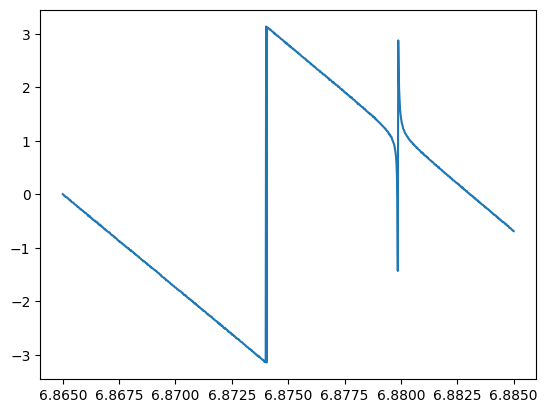

In [71]:
plt.plot(spec_freq/1e9, np.angle(sweep_resonator_results_delayed[0]))

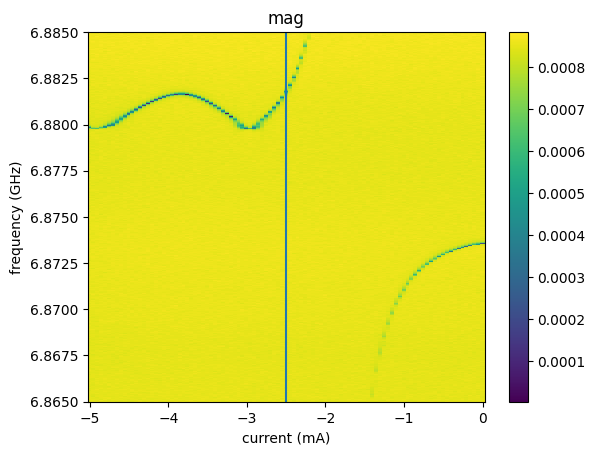

In [74]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_resonator_results_delayed).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
# plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
plt.axvline(-2.5)
# current_sweep[8]*1e3

(1800.0, 1875.0)

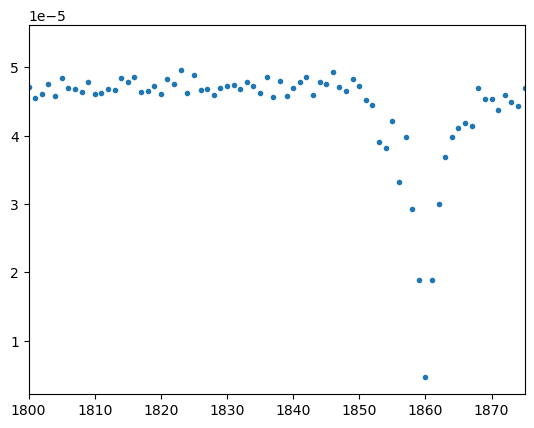

In [555]:
plt.plot(np.abs(sweep_resonator_results_delayed)[0,:],'.')
plt.xlim(1800,1875)

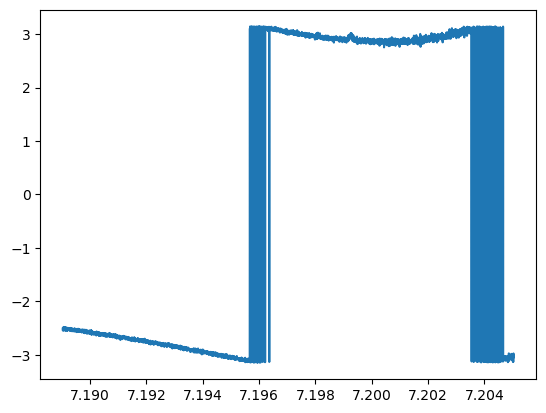

In [213]:
plt.plot(spec_freq/1e9, np.angle(sweep_resonator_results_delayed)[16,:])
# plt.axvline(6.887)

Text(0.5, 1.0, 'phase')

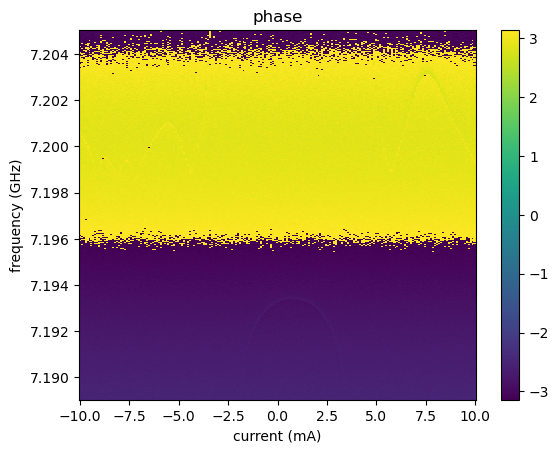

In [211]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.unwrap(np.angle(sweep_resonator_results_delayed).T))
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('phase')
# plt.ylim(7.19, 7.21)
# plt.clim(5e-5, 7e-5)
# plt.axvline(current_sweep[16]*1e3)

#### fit

Resonant frequency: 7204001653.765517 GHz


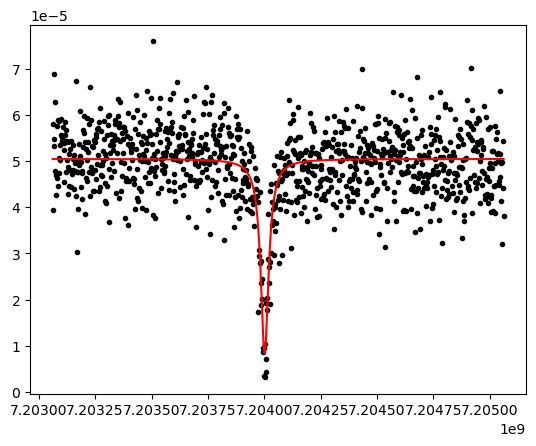

In [37]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

In [34]:
p_opt

array([ 2.11711721e+04,  7.20400165e+09, -8.91050316e-01,  5.04768683e-05])

Resonant frequency: 7584694405.15963 GHz


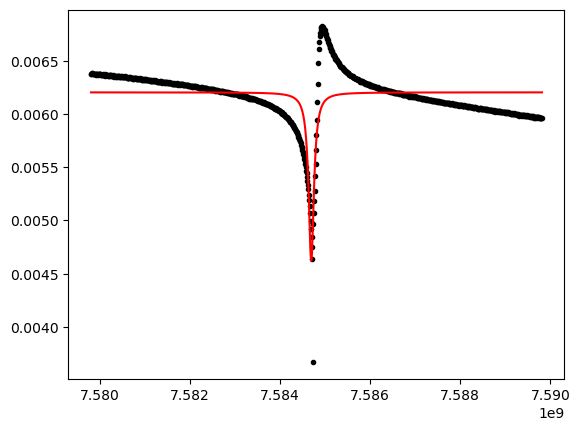

In [206]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

In [209]:
p_opt

array([ 7.02028634e+04,  7.58469441e+09, -1.11375608e+02,  6.20200071e-03])

In [38]:
#Simple min/max works for initial tune-up
opt_freq = spec_freq[np.argmin(abs(spec_res))]
# opt_freq = 6.58230639e9
print(f"Resonant frequency: {opt_freq*1e-9} GHz")

Resonant frequency: 7.20400152 GHz


#### 3.1.4 Update Calibration

In [36]:
if not emulate:
    # update qubit parameter dictionary with results from data fitting
    measure_q.parameters.readout_resonator_frequency = opt_freq
    # update calibration

    # apply calibration to device setup
    device_setup.set_calibration(
        measure_q.calibration()
    )

### 3.1 Resonator Spectroscopy w/ power: CW

Find the resonance frequency of the qubit readout resonator by looking at the transmission or reflection of a probe signal applied through the readout line

#### 3.1.1 Additional Experimental Parameters

Define the frequency scan

In [174]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -0.5e6
stop_freq = .5e6
num_points = 1001
integration_time = 2e-3
num_averages = 1
power_sweep = np.linspace(0,1,11)

#### 3.1.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [175]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter
def res_spectroscopy_CW(freq_sweep, exp_settings):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec.acquire_loop_rt(
        uid="shots",
        count=exp_settings["num_averages"],
        acquisition_type=AcquisitionType.SPECTROSCOPY,
    ):
        with exp_spec.sweep(uid="res_freq", parameter=freq_sweep):
            # readout pulse and data acquisition
            with exp_spec.section(uid="spectroscopy"):
                # resonator signal readout
                exp_spec.acquire(
                    signal="acquire",
                    handle="res_spec",
                    length=exp_settings["integration_time"],
                )
            with exp_spec.section(uid="delay", length=1e-6):
                # holdoff time after signal acquisition
                exp_spec.reserve(signal="measure")

    return exp_spec

#### 3.1.3 Run and Evaluate Experiment
Runs the experiment and evaluates the data returned by the measurement

In [168]:
measure_q.parameters.readout_range_out = 10
measure_q.parameters.readout_range_in = -20
# measure_q.parameters.readout_range_out = 10
# measure_q.parameters.readout_range_in = 5
measure_q.parameters.user_defined['readout_amp'] = 1

In [321]:
measure_q.parameters.readout_lo_frequency = 7.0e9
measure_q.parameters.readout_resonator_frequency = 7.2085e9

In [169]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5875000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=7204009725.119428,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=0,
│   │   readout_range_out=10,
│   │   readout_range_in=-20,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 1,
│   │   │   'pulse_length': 1e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 1,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [170]:
device_setup.set_calibration(measure_q.calibration())

In [171]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -0.2e6
stop_freq = 0.2e6
num_points = 101
integration_time = 2e-3
num_averages = 2

In [172]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [176]:
res_spec_results_punchout = []
for power in power_sweep:
    measure_q.parameters.user_defined['readout_amp'] = power
    device_setup.set_calibration(measure_q.calibration())
    # frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
    # start_freq = -0.005e9
    # stop_freq = 0.005e9
    # num_points = 1001
    # integration_time = 2e-3
    # num_averages = 2
    
    freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
    exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
    exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)
    
    exp_spec.set_calibration(res_spec_calib(freq_sweep))
    exp_spec.set_signal_map(res_spec_map(measure_q))

    # run the experiment on the open instrument session
    compiled_res_spec = session.compile(exp_spec)
    res_spec_results = session.run()
    
    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
    print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")

    res_spec_results_punchout.append(res_spec_results.get_data("res_spec"))

[2024.05.14 12:53:12.434] INFO    Starting LabOne Q Compiler run...
[2024.05.14 12:53:12.508] INFO    Schedule completed. [0.069 s]
[2024.05.14 12:53:12.625] INFO    Code generation completed for all AWGs. [0.115 s]
[2024.05.14 12:53:12.627] INFO    Completed compilation step 1 of 1. [0.189 s]
[2024.05.14 12:53:12.630] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.14 12:53:12.632] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.14 12:53:12.633] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.14 12:53:12.635] INFO      device_shfqc     0         25            0           0         0  
[2024.05.14 12:53:12.636] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.14 12:53:12.638] INFO      TOTAL                      25            0                     0  
[2024.05.14 12:53:12.639] INFO     ────────────────────────────────────────────────────

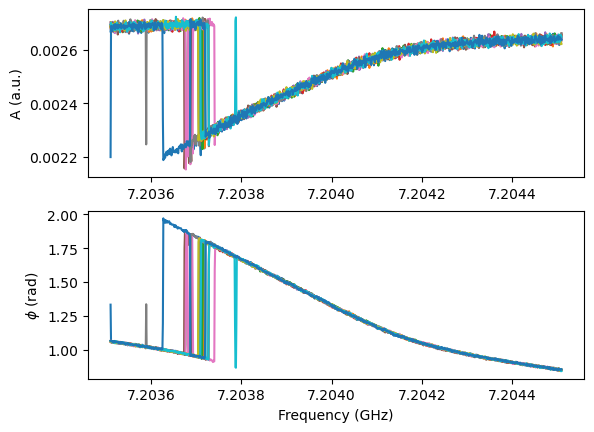

In [177]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = res_spec_results.get_data("res_spec")
# define the frequency axis from the qubit parameters
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_frequency * (0.995 + 0.01 * np.random.rand(1)[0])
        + measure_q.parameters.readout_lo_frequency,
        -1e7,
        10,
    ) + 0.2 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
for i, power in enumerate(power_sweep):
    ax1.plot(spec_freq / 1e9, abs(res_spec_results_punchout[i]), label = f'{power}')
    ax2.plot(spec_freq / 1e9, np.unwrap(np.angle(res_spec_results_punchout[i])), label = f'{power}')
    ax1.set_ylabel("A (a.u.)")
    ax2.set_ylabel("$\\phi$ (rad)")
    ax2.set_xlabel("Frequency (GHz)")
    # ax2.axvline(6582311900.0/1e9)
    
plt.show()

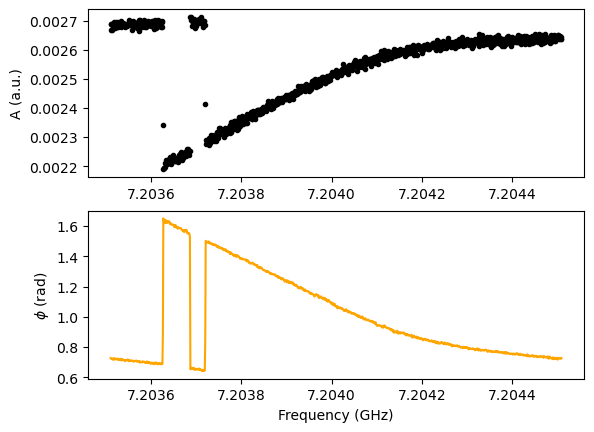

In [178]:
manual_phase_linear_factor = (np.unwrap(np.angle(spec_res))[-1]-np.unwrap(np.angle(spec_res))[0])/(spec_freq[-1]-spec_freq[0])
spec_res_delayed = spec_res * np.exp(-manual_phase_linear_factor*spec_freq*1j)
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res_delayed), ".k")
ax2.plot(spec_freq / 1e9, np.angle(spec_res_delayed), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax2.axvline(6582311900.0/1e9)

plt.show()

#### flux sweep resonator

In [1394]:
measure_q.parameters.readout_range_out = 10
measure_q.parameters.readout_range_in = -20
# measure_q.parameters.readout_range_out = 10
# measure_q.parameters.readout_range_in = 5
measure_q.parameters.user_defined['readout_amp'] = 0.5

In [1395]:
measure_q.parameters.readout_lo_frequency = 7.0e9
measure_q.parameters.readout_resonator_frequency = 6.87e9

In [1396]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5982000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=5800000000.0,
│   │   readout_resonator_frequency=6870000000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=5,
│   │   readout_range_out=10,
│   │   readout_range_in=-20,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 3.5e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.5,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [1397]:
device_setup.set_calibration(measure_q.calibration())

In [1398]:
# frequency range of spectroscopy scan - around expected resonator frequency as defined in qubit parameters
start_freq = -0.025e9
stop_freq = 0.025e9
num_points = 1001
integration_time = 2e-3
num_averages = 2

In [1399]:
# define the experiment with the frequency sweep relevant for qubit 0
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)
exp_settings = {"integration_time": integration_time, "num_averages": num_averages}
exp_spec = res_spectroscopy_CW(freq_sweep, exp_settings)

# set signal calibration and signal map for experiment
exp_spec.set_calibration(res_spec_calib(freq_sweep))

In [536]:
dc.ramp_current(0e-3,1e-5,0)

In [ ]:
freq_sweep

In [1400]:
current_range = 10e-3
current_sweep = np.linspace(current_range, -current_range, 201)
# dc.ramp_current(0, 1e-5, 0)
dc.output('on')
sweep_resonator_results = []
sweep_resonator_results_delayed = []
for current in current_sweep:
    dc.ramp_current(current, 1e-6, 0)
    time.sleep(0.05)
    exp_spec.set_signal_map(res_spec_map(measure_q))

    # run the experiment on the open instrument session
    compiled_res_spec = session.compile(exp_spec)
    res_spec_results = session.run()
    
    # save the data
    timestamp = time.strftime("%Y%m%dT%H%M%S")
    Path("Results_Needed").mkdir(parents=True, exist_ok=True)
    session.save_results(f"Results_Needed/res_spec_results_{timestamp}.json")
    # print(f"File saved as Results_Needed/res_spec_results_{timestamp}.json")
    sweep_resonator_results.append(res_spec_results.get_data("res_spec"))
    spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]

    spec_res_delayed = res_spec_results.get_data("res_spec") * np.exp(-manual_phase_linear_factor*spec_freq*1j)
    sweep_resonator_results_delayed.append(spec_res_delayed)
    

plt.show()
dc.ramp_current(0,1e-6,0)

[2024.04.17 16:49:27.339] INFO    Starting LabOne Q Compiler run...
[2024.04.17 16:49:27.399] INFO    Schedule completed. [0.057 s]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1164, in emit
    self.flush()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1144, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\qn

[2024.04.17 16:49:27.609] INFO    Code generation completed for all AWGs. [0.208 s]
[2024.04.17 16:49:27.610] INFO    Completed compilation step 1 of 1. [0.269 s]
[2024.04.17 16:49:27.613] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 16:49:27.614] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.04.17 16:49:27.615] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 16:49:27.616] INFO      device_shfqc     0         27            0           0         0  
[2024.04.17 16:49:27.617] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 16:49:27.618] INFO      TOTAL                      27            0                     0  
[2024.04.17 16:49:27.619] INFO     ────────────────────────────────────────────────────────────────── 
[2024.04.17 16:49:27.621] INFO    Finished LabOne Q Compiler run.
[2024.04.17 16:49:27.624] INFO    Configuring the 

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1164, in emit
    self.flush()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1144, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
    app.start()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\qn

[2024.04.17 16:49:28.751] INFO    Starting near-time execution...


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1164, in emit
    self.flush()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1144, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1030, in _bootstrap
    self._bootstrap_inner()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\unsync\unsync.py", line 44, in _thread_target
    loop.run_forever()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\asyncio\windows_events.py", line 321, in run_forever
    super().run_forever()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\asyncio\base_events.py",

[2024.04.17 16:49:33.480] INFO    Finished near-time execution.


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1164, in emit
    self.flush()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\logging\__init__.py", line 1144, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1030, in _bootstrap
    self._bootstrap_inner()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\site-packages\unsync\unsync.py", line 44, in _thread_target
    loop.run_forever()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\asyncio\windows_events.py", line 321, in run_forever
    super().run_forever()
  File "C:\Users\qnlbe\.conda\envs\laboneq\Lib\asyncio\base_events.py",

NameError: name 'manual_phase_linear_factor' is not defined

In [232]:
spec_freq = measure_q.parameters.readout_lo_frequency + res_spec_results.get_axis("res_spec")[0]

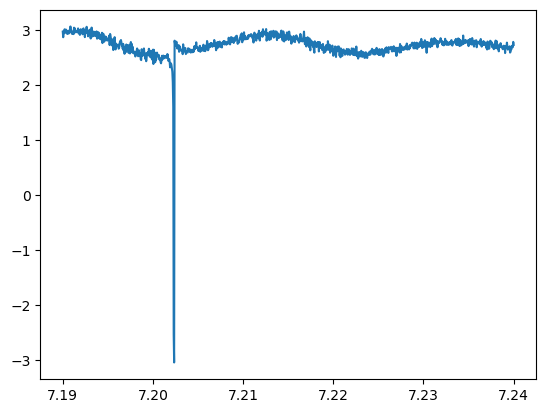

In [106]:
plt.plot(spec_freq/1e9, np.angle(sweep_resonator_results_delayed[0]))

(7.19, 7.215)

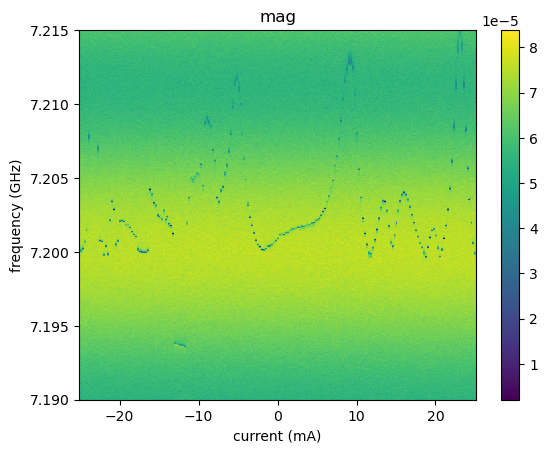

In [300]:
plt.pcolor( current_sweep*1e3,spec_freq/1e9, np.abs(sweep_resonator_results_delayed).T)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
plt.ylim(7.19, 7.215)
# plt.clim(-0.0014, 0.0016)
# plt.axvline(current_sweep[17]*1e3)

In [108]:
# X = current_sweep*1e3
# Y = spec_freq/1e9
# Z =  sweep_resonator_results_delayed
# ZZ =  np.angle(Z).T

(7.19, 7.215)

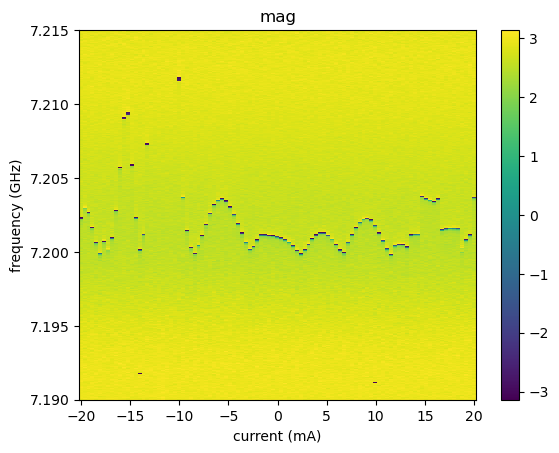

In [113]:
plt.pcolor( X,Y, ZZ)
plt.ylabel('frequency (GHz)')
plt.xlabel('current (mA)')
plt.colorbar()
plt.title('mag')
plt.ylim(7.19, 7.215)

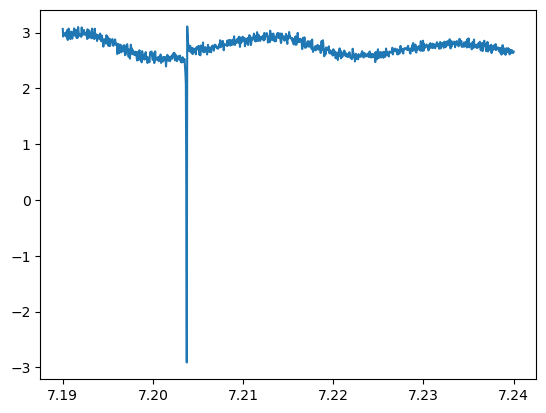

In [109]:
plt.plot(spec_freq/1e9,np.angle(sweep_resonator_results_delayed[26]))

#### fit

Resonant frequency: 6884818162.613441 GHz


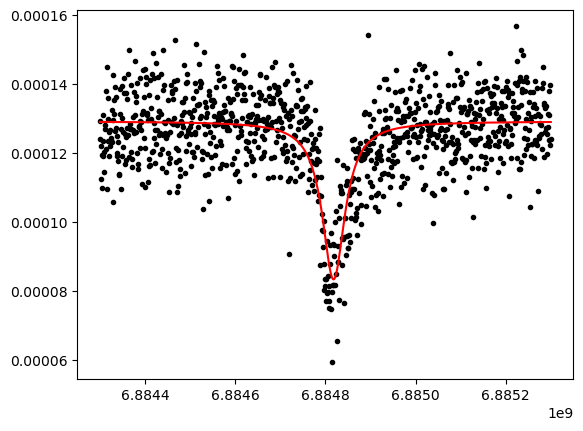

In [42]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

In [340]:
p_opt

array([9.50163611e+04, 6.58230637e+09, 1.60247308e+02, 8.98595426e-03])

Resonant frequency: 7194253052.774475 GHz


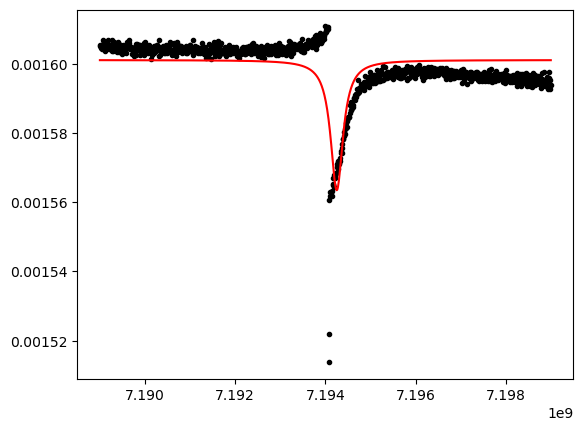

In [80]:
#Lorentzian fit requires roughly close starting values
(p_opt, b) = lorentzian.fit(
    spec_freq,
    abs(spec_res),
    100e3,
    q0.parameters.readout_resonator_frequency,
    -1e7,
    1,
    plot=True,
)
opt_freq = p_opt[1]
print(f"Resonant frequency: {opt_freq} GHz")

In [342]:
p_opt

array([9.50163611e+04, 6.58230637e+09, 1.60247308e+02, 8.98595426e-03])

In [302]:
#Simple min/max works for initial tune-up
opt_freq = spec_freq[np.argmax(abs(spec_res))]
opt_freq = 7.20875e9
print(f"Resonant frequency: {opt_freq*1e-9} GHz")

Resonant frequency: 7.20875 GHz


#### 3.1.4 Update Calibration

In [303]:
if not emulate:
    # update qubit parameter dictionary with results from data fitting
    measure_q.parameters.readout_resonator_frequency = opt_freq
    # update calibration

    # apply calibration to device setup
    device_setup.set_calibration(
        measure_q.calibration()
    )

### 3.2 Resonator Spectroscopy: Pulsed

#### 3.2.1 Additional Experimental Parameters

Define the frequency scan and the pulse

In [12]:
# dc.ramp_current(-3.5e-3, 1e-6, 0)

In [157]:
measure_q.parameters.readout_resonator_frequency = 6.8835e9
measure_q.parameters.readout_range_out = -15
measure_q.parameters.readout_range_in = 0
measure_q.parameters.user_defined['readout_amp'] = 0.5

In [158]:
# frequency range of spectroscopy scan -
# around expected resonator frequency as defined in qubit parameters
start_freq = -2e6
stop_freq =2e6
num_points = 201

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 11

readout_pulse = create_readout_pulse(measure_q)

In [159]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5736200000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6883500000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=-5,
│   │   readout_range_out=-15,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.4,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.5,
│   │   │   'reset_length': 1e-05
│   │   }
│   )
)

#### 3.2.2 Experiment Definition

In [160]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter


def res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec_pulsed = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency

    # inner loop - average multiple measurements for each frequency - measurement in spectroscopy mode
    with exp_spec_pulsed.acquire_loop_rt(
        uid="shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.SPECTROSCOPY,
        averaging_mode=AveragingMode.SEQUENTIAL,
    ):
        with exp_spec_pulsed.sweep(
            uid="res_freq",
            parameter=freq_sweep,
            chunk_count=1,
        ):
            # readout pulse and data acquisition
            with exp_spec_pulsed.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_spec_pulsed.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_spec_pulsed.acquire(
                    signal="acquire", handle="res_spec_pulsed", length=readout_pulse.length
                )
            with exp_spec_pulsed.section(uid="delay", length=100e-6):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_spec_pulsed.reserve(signal="measure")

    return exp_spec_pulsed

#### 3.2.3 Apply Experiment Parameters and Compile

In [161]:
# measure_q.parameters.readout_range_out = 10

# # apply calibration to device setup
# device_setup.set_calibration(
#     measure_q.calibration()
# )

In [162]:
# create freq sweep
freq_sweep = create_readout_freq_sweep(measure_q, start_freq, stop_freq, num_points)

# define the experiment with the frequency sweep relevant for qubit
exp_spec_pulsed = res_spectroscopy_pulsed(freq_sweep, num_averages, readout_pulse)

# set signal calibration and signal map for experiment to qubit
exp_spec_pulsed.set_calibration(res_spec_calib(freq_sweep))
exp_spec_pulsed.set_signal_map(res_spec_map(measure_q))

In [163]:
freq_sweep

LinearSweepParameter(uid='res_freq_q0', start=-118500000.0, stop=-114500000.0, count=201, axis_name=None)

In [164]:
# compile the experiment on the open instrument session
compiled_spec_pulsed = session.compile(exp_spec_pulsed)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)

# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Pulsed_Spectroscopy", compiled_spec_pulsed)

[2024.06.13 16:26:59.457] INFO    Starting LabOne Q Compiler run...
[2024.06.13 16:26:59.481] INFO    Schedule completed. [0.021 s]
[2024.06.13 16:26:59.543] INFO    Code generation completed for all AWGs. [0.065 s]
[2024.06.13 16:26:59.543] INFO    Completed compilation step 1 of 1. [0.089 s]
[2024.06.13 16:26:59.543] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 16:26:59.543] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.13 16:26:59.553] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 16:26:59.553] INFO      device_shfqc     0         25            0           1      8000  
[2024.06.13 16:26:59.553] INFO     ────────────────────────────────────────────────────────────────── 
[2024.06.13 16:26:59.553] INFO      TOTAL                      25            0                  8000  
[2024.06.13 16:26:59.553] INFO     ────────────────────────────────────────────────────

Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Pulsed_Spectroscopy_2024-06-13-16-26-59.html

#### 3.2.4 Run and Evaluate Experiment

In [165]:
# run the experiment on the open instrument session
spec_pulsed_results = session.run()

# save the data
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_pulsed_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_pulsed_results_{timestamp}.json")

[2024.06.13 16:26:59.722] INFO    Configuring the device setup
[2024.06.13 16:26:59.836] INFO    The device setup is configured
[2024.06.13 16:27:01.255] INFO    Starting near-time execution...
[2024.06.13 16:27:01.712] INFO    Estimated RT execution time: 41.99 s.
[2024.06.13 16:27:43.977] INFO    Finished near-time execution.
File saved as Results_Needed/spec_pulsed_results_20240613T162744.json


6.88382

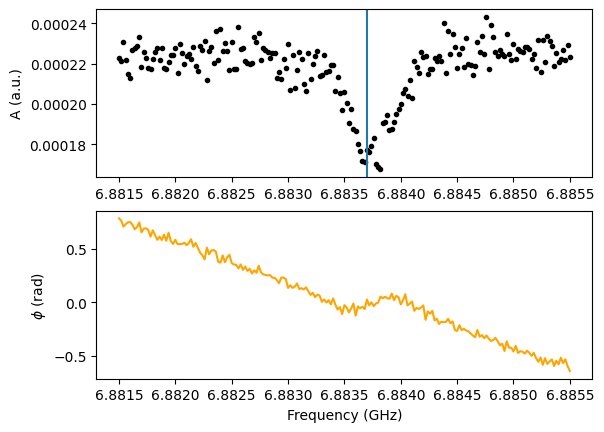

In [168]:
# get the measurement data returned by the instruments from the QCCS session
spec_res = spec_pulsed_results.get_data("res_spec_pulsed")
# define the frequency axis from the qubit parameters
spec_freq = (
    measure_q.parameters.readout_lo_frequency + spec_pulsed_results.get_axis("res_spec_pulsed")[0]
)

if emulate:
    # create some dummy data if running in emulation mode
    spec_res = lorentzian(
        spec_freq,
        10e6,
        measure_q.parameters.readout_resonator_frequency * (0.995 + 0.01 * np.random.rand(1)[0]),
        -2e6,
        1,
    ) + 0.1 * np.random.rand(len(spec_freq))

# plot the measurement data
fig, [ax1, ax2] = plt.subplots(2, 1)
ax1.plot(spec_freq / 1e9, abs(spec_res), ".k")
ax2.plot(spec_freq / 1e9, np.unwrap(np.angle(spec_res)), "orange")
ax1.set_ylabel("A (a.u.)")
ax2.set_ylabel("$\\phi$ (rad)")
ax2.set_xlabel("Frequency (GHz)")
# ax1.axvline(spec_freq[np.argmin(abs(spec_res))]/1e9)
ax1.axvline(6.8837)
spec_freq[np.argmin(abs(spec_res))]/1e9

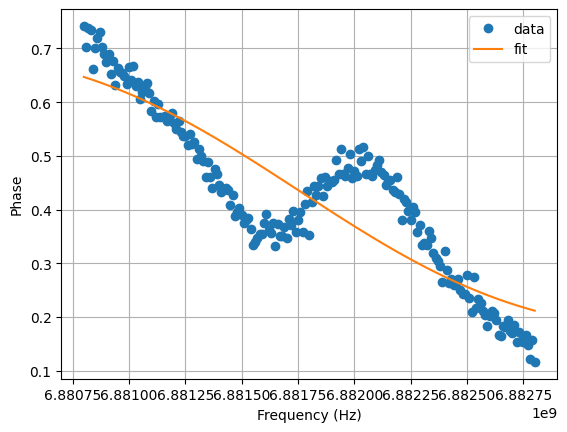

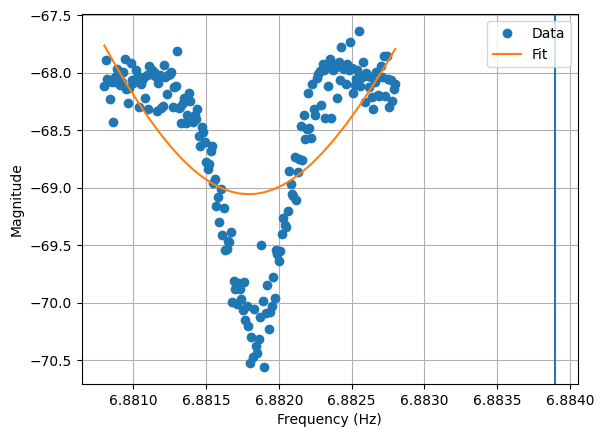

{'a': 0.010973258833114454,
 'b': -0.0034447499357186085,
 'f0': 6840178967.072203,
 'kappa': -74163492.18080015,
 'kappa_int': -38790014.78504297,
 'kappa_ext': 35373477.39575718,
 'Q': -92.2310798202006,
 'Qe': 193.37027260691755,
 'Qi': 350.6710300427534,
 'phi': -4.007415020907311,
 'tau': 2.997730757629323e-07}

In [106]:
freqs =spec_freq 
dataComplex=spec_res
params = res_fit.resonator_regression(freqs,dataComplex)[0];
cov= res_fit.resonator_regression(freqs,dataComplex)[1];
fit_data = res_fit.resonator_f_to_S(freqs,*params)
tau=res_fit.reflection_resonator_params(*params,covar=cov)['tau']
f0=res_fit.reflection_resonator_params(*params,covar=cov)['f0']

readout_frequency = f0


# phase 
plt.plot(freqs,np.unwrap(np.angle(dataComplex)),'o', label='data')
plt.plot(freqs,np.unwrap(np.angle(fit_data)), label='fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Mag
plt.plot(freqs/1e9,20*np.log10(abs(dataComplex)), 'o',label='Data')
plt.plot(freqs/1e9,20*np.log10(abs(fit_data)), label='Fit')
plt.axvline(6.8839)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend(loc='upper right')  
plt.grid()
plt.show()
# params

res_fit.reflection_resonator_params(*params,covar=cov)

#### 3.2.5 Update calibration
Extract the resonance frequency and update the calibration

In [41]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=6872278239.826937,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=10,
│   │   readout_range_out=10,
│   │   readout_range_in=-20,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 1,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

Resonant frequency: 6886906049.238896 GHz


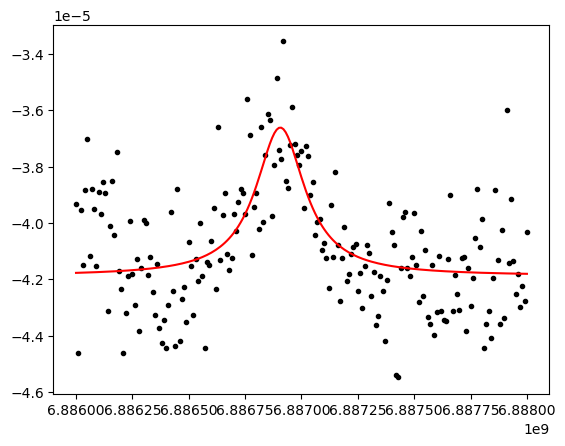

In [1162]:
if not emulate:
    (p_opt, b) = lorentzian.fit(
        spec_freq,
        -abs(spec_res),
        0.1e6,
        measure_q.parameters.readout_resonator_frequency,
        -1e5,
        1,
        plot=True,
    )
    opt_freq = p_opt[1]
    print(f"Resonant frequency: {opt_freq} GHz")
    measure_q.parameters.readout_resonator_frequency = opt_freq
    device_setup.set_calibration(
        measure_q.calibration()
    )

In [1163]:
p_opt

array([ 1.31959031e+05,  6.88690605e+09,  6.95383752e-01, -4.18834412e-05])

In [1164]:
#Simple minimum calculation
opt_freq = p_opt[1]
spec_freq[np.argmin(abs(spec_res))]
# opt_freq = 7.2085e9
measure_q.parameters.readout_resonator_frequency = opt_freq
opt_freq

6886906049.238896

#### Update calibration

In [1165]:
if not emulate:
    # update qubit parameter dictionary with results from data fitting
    measure_q.parameters.readout_resonator_frequency = opt_freq
    # update calibration

    # apply calibration to device setup
    device_setup.set_calibration(
        measure_q.calibration()
    )

### 3.3 Resonator Spectroscopy v/ Power
* _It is possible to define the spectroscopy experiments in a more general way, so that CW and pulsed spectroscopy can be chosen with an argument to the function. However, this is not done here for the sake of clarity. Pulsed measurements are used to more closely match final readout pulse_
#### 3.3.1 Additional experimental parameters

In [279]:
# frequency range of spectroscopy scan -
# around expected centre frequency as defined in qubit parameters
start_freq = -0.2e6
stop_freq = 0.2e6
num_freq_points = 501

# set number of points for amplitude sweep
num_amp_points = 51

In [43]:
num_averages = 10

In [44]:
measure_q.parameters.readout_range_out = 0
measure_q.parameters.readout_range_in = 10
measure_q.parameters.readout_resonator_frequency = 7.58481e9
device_setup.set_calibration(measure_q.calibration())

In [45]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=7584810000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=10,
│   │   readout_range_out=0,
│   │   readout_range_in=10,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 1,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

#### 3.3.2 Experiment Definition

In [21]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep and amplitude sweeps as parameters


def res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_spec = Experiment(
        uid="Resonator Spectroscopy",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive amplitude
    with exp_spec.sweep(uid="res_amp", parameter=amplitude_sweep):
        with exp_spec.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.SPECTROSCOPY,
        ):
            #inner loop - sweep frequency
            with exp_spec.sweep(uid="res_freq", parameter=frequency_sweep):
                # readout pulse and data acquisition
                with exp_spec.section(uid="spectroscopy"):
                    # play resonator excitation pulse
                    exp_spec.play(signal="measure", pulse=readout_pulse)
                    # resonator signal readout
                    exp_spec.acquire(
                        signal="acquire",
                        handle="res_spec_pulsed",
                        length=readout_pulse.length,
                    )
                with exp_spec.section(uid="delay"):
                    # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                    exp_spec.delay(signal="measure", time=1e-6)

    return exp_spec

#### 3.3.3 Apply Experiment Parameters and Compile

In [291]:
amplitude_sweep = LinearSweepParameter(
    uid="amp_sweep_param", start=0.01, stop=0.99, count=num_amp_points
)

readout_pulse = create_readout_pulse(measure_q)
frequency_sweep = create_readout_freq_sweep(
    measure_q, start_freq, stop_freq, num_freq_points
)

exp_spec_amp = res_spectroscopy_pulsed_amp_sweep(
    frequency_sweep, amplitude_sweep, num_averages, readout_pulse
)

exp_spec_amp.set_calibration(res_spec_calib(frequency_sweep, amplitude_sweep))
exp_spec_amp.set_signal_map(res_spec_map(measure_q))

NameError: name 'num_amp_points' is not defined

In [177]:
# compile the experiment on the open instrument session
compiled_spec_amp = session.compile(exp_spec_amp)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet(
    "Pulse_Sheets/Spectroscopy_vs_Amplitude_Pulse_Sheet", compiled_spec_amp
)

[2024.05.02 19:21:59.016] INFO    Starting LabOne Q Compiler run...
[2024.05.02 19:21:59.058] INFO    Schedule completed. [0.038 s]
[2024.05.02 19:21:59.280] INFO    Code generation completed for all AWGs. [0.220 s]
[2024.05.02 19:21:59.282] INFO    Completed compilation step 1 of 51. [0.263 s]
[2024.05.02 19:21:59.284] INFO    Skipping compilation for next step(s)...
[2024.05.02 19:21:59.287] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.02 19:21:59.288] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.02 19:21:59.290] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.02 19:21:59.292] INFO      device_shfqc     0         21            0           1      8000  
[2024.05.02 19:21:59.293] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.02 19:21:59.295] INFO      TOTAL                      21            0                  8000  
[2024.05.02

Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Spectroscopy_vs_Amplitude_Pulse_Sheet_2024-05-02-19-21-59.html

In [178]:
# run the compiled experiemnt
spec_amp_results = session.run(compiled_spec_amp)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/spec_amp_results_{timestamp}.json")
print(f"File saved as Results_Needed/spec_amp_results_{timestamp}.json")

[2024.05.02 19:22:07.980] INFO    Configuring the device setup
[2024.05.02 19:22:08.084] INFO    The device setup is configured
[2024.05.02 19:22:09.380] INFO    Starting near-time execution...
[2024.05.02 19:24:04.236] INFO    Finished near-time execution.
File saved as Results_Needed/spec_amp_results_20240502T192404.json


#### 3.3.4 Run and Evaluate Experiment

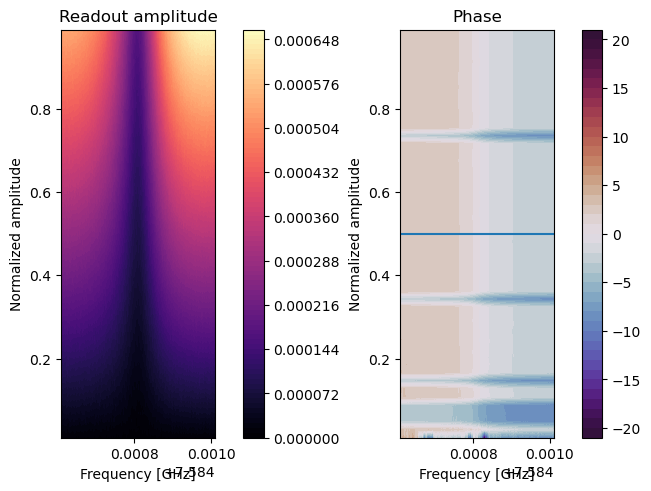

In [179]:
# plot the results
lo_freq = measure_q.parameters.readout_lo_frequency
spec_freq = lo_freq + spec_amp_results.get_axis("res_spec_pulsed")[1]
amp = spec_amp_results.get_axis("res_spec_pulsed")[0]
data = spec_amp_results.get_data("res_spec_pulsed")

X, Y = np.meshgrid(spec_freq, amp)
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
CS = ax[0].contourf(X / 1e9, Y, np.abs(data), levels=100, cmap="magma")
ax[0].set_title("Readout amplitude")
ax[0].set_xlabel("Frequency [GHz]")
ax[0].set_ylabel("Normalized amplitude")
fig.colorbar(CS)

max_value = (
    max(
        int(np.abs(np.min(np.unwrap(np.angle(data, deg=False))))),
        int(np.abs(np.max(np.unwrap(np.angle(data, deg=False))))),
    )
    + 1
)

cs2_levels = np.linspace(-max_value, max_value, 2 * (max_value) + 1)

CS2 = ax[1].contourf(
    X / 1e9,
    Y,
    np.unwrap(np.angle(data, deg=False)),
    levels=cs2_levels,
    cmap="twilight_shifted",
)
ax[1].set_title("Phase")
ax[1].set_xlabel("Frequency [GHz]")
ax[1].set_ylabel("Normalized amplitude")
fig.colorbar(CS2)
plt.axhline(amp[25])

In [700]:
# plt.plot(np.angle(data[0]))
# plt.plot(np.angle(data[-2]))

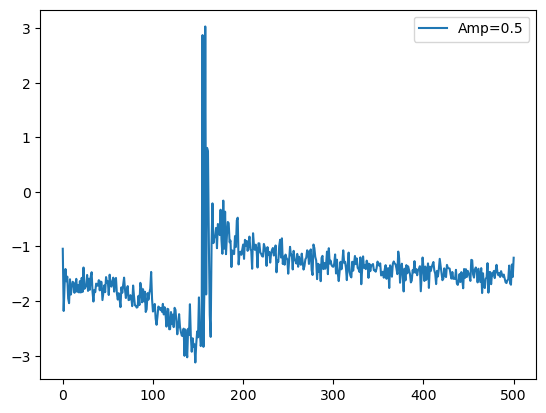

In [785]:
# plt.plot(abs(data[0]))
# plt.plot(np.angle(data[0]), label=f'Amp={amp[0]}')
# plt.plot(np.angle(data[10]), label=f'Amp={amp[10]}')
# plt.plot(np.angle(data[20]), label=f'Amp={amp[20]}')
plt.plot(np.angle(data[25]), label=f'Amp={amp[25]}')
plt.legend()

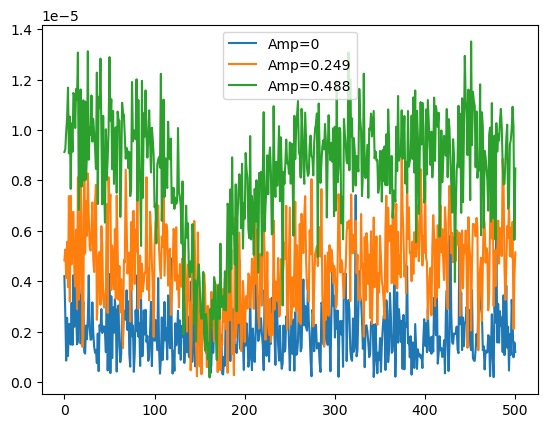

In [776]:
# plt.plot(abs(data[0]))
plt.plot(abs(data[0]), label='Amp=0')
plt.plot(abs(data[10]), label='Amp=0.249')
plt.plot(abs(data[20]), label='Amp=0.488')
plt.legend()

In [650]:
measure_q.parameters.user_defined['readout_range_out'] = -10
measure_q.parameters.user_defined['readout_range_in'] = -15
measure_q.parameters.user_defined['readout_amp'] = 0.3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=7200900000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=5e-08,
│   │   drive_range=10,
│   │   readout_range_out=-10,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.3,
│   │   │   'reset_length': 5e-06,
│   │   │   'readout_range_out': -10,
│   │   │   'readout_range_in': -15
│   │   }
│   )
)

### 3.4 Propagation Delay
Sweep the delay of the integration, and then find the maximum result
#### 3.4.1 Additional experimental parameters
values are relative to the default 212 ns delay

In [280]:
measure_q.parameters.readout_resonator_frequency = 6.87096594e9 #opt_freq
# measure_q.parameters.readout_resonator_frequency = 6582350000.0
# measure_q.parameters.readout_integration_delay = 0e-9
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=6870965940.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=10,
│   │   readout_range_out=10,
│   │   readout_range_in=-50,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 5e-06
│   │   }
│   )
)

In [287]:
# define delay sweep
delay_sweep = LinearSweepParameter(
    uid="delay_sweep_param", start=-200e-9, stop=1000e-9, count=41
    # uid="delay_sweep_param", start=400-9, stop=500e-9, count=21
)

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12#12

#### 3.4.2 Experiment Definition

In [288]:
# function that defines a resonator spectroscopy experiment, and takes the frequency sweep as a parameter


def propagation_delay(readout_pulse, delay_sweep):
    # Create resonator spectroscopy experiment - uses only readout drive and signal acquisition
    exp_prop_delay = Experiment(
        uid="Propagation Delay Measurement",
        signals=[
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define experimental sequence
    # outer loop - vary drive frequency
    with exp_prop_delay.sweep(uid="del_sweep", parameter=delay_sweep):
        with exp_prop_delay.acquire_loop_rt(
            uid="shots",
            count=2**num_averages,
            acquisition_type=AcquisitionType.INTEGRATION,
        ):
            
            # readout pulse and data acquisition
            with exp_prop_delay.section(uid="spectroscopy"):
                # play resonator excitation pulse
                exp_prop_delay.play(signal="measure", pulse=readout_pulse)
                # resonator signal readout
                exp_prop_delay.acquire(
                    signal="acquire", handle="res_prop_delay", kernel=readout_pulse
                )
            with exp_prop_delay.section(uid="delay"):
                # holdoff time after signal acquisition - minimum 1us required for data processing on UHFQA
                exp_prop_delay.delay(signal="measure", time=20e-6)

            cal = Calibration()
            cal["acquire"] = SignalCalibration(
                port_delay=delay_sweep,
            )
            exp_prop_delay.set_calibration(cal)

    return exp_prop_delay

#### 3.4.3 Apply Experiment Parameters and Compile

In [337]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=3150000000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6100000000.0,
│   │   readout_resonator_frequency=6000000000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=9.999999999999984e-09,
│   │   drive_range=10,
│   │   readout_range_out=10,
│   │   readout_range_in=-50,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.5,
│   │   │   'pulse_length': 5e-08,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 1e-06
│   │   }
│   )
)

In [336]:
measure_q.parameters.readout_range_out = 10
measure_q.parameters.readout_range_in = -50
# measure_q.parameters.user_defined['reset_length']=1e-06
device_setup.set_calibration(measure_q.calibration())

In [338]:
short_readout_pulse = create_readout_pulse(measure_q)

device_setup.set_calibration(
    measure_q.calibration()
)

exp_prop_delay = propagation_delay(short_readout_pulse, delay_sweep)

exp_prop_delay.set_signal_map(res_spec_map(measure_q))

In [339]:
# compile the experiment on the open instrument session
compiled_prop_delay = session.compile(exp_prop_delay)

Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# generate a pulse sheet to inspect experiment before runtime
show_pulse_sheet("Pulse_Sheets/Propagation_delay", compiled_prop_delay)

[2024.05.30 16:45:55.776] INFO    Starting LabOne Q Compiler run...
[2024.05.30 16:45:55.776] INFO    Schedule completed. [0.000 s]
[2024.05.30 16:45:55.787] INFO    Code generation completed for all AWGs. [0.004 s]
[2024.05.30 16:45:55.789] INFO    Completed compilation step 1 of 41. [0.007 s]
[2024.05.30 16:45:55.790] INFO    Skipping compilation for next step(s)...
[2024.05.30 16:45:55.793] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.30 16:45:55.794] INFO      Device         AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.30 16:45:55.795] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.30 16:45:55.796] INFO      device_shfqc     0          7            0           1      8000  
[2024.05.30 16:45:55.797] INFO     ────────────────────────────────────────────────────────────────── 
[2024.05.30 16:45:55.798] INFO      TOTAL                       7            0                  8000  
[2024.05.30

Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Propagation_delay_2024-05-30-16-45-55.html

#### 3.4.4 Run and Evaluate Experiment

In [340]:
# run the compiled experiemnt
prop_delay_results = session.run(compiled_prop_delay)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/{timestamp}_prop_delay_results.json")
print(f"File saved as Results/{timestamp}_prop_delay_results.json")

[2024.05.30 16:45:57.587] INFO    Configuring the device setup
[2024.05.30 16:45:57.698] INFO    The device setup is configured
[2024.05.30 16:45:58.716] INFO    Starting near-time execution...
[2024.05.30 16:46:32.685] INFO    Finished near-time execution.
File saved as Results/20240530T164632_prop_delay_results.json


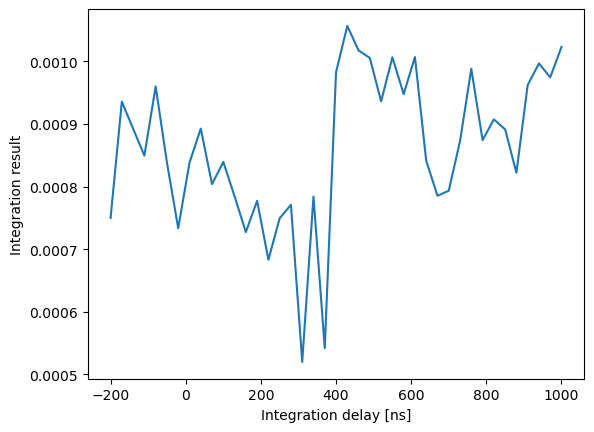

In [322]:
dat = prop_delay_results.get_data("res_prop_delay")
ax = prop_delay_results.get_axis("res_prop_delay")[0]

plt.plot(ax * 1e9, np.abs(dat))
plt.xlabel("Integration delay [ns]")
plt.ylabel("Integration result")
plt.show()

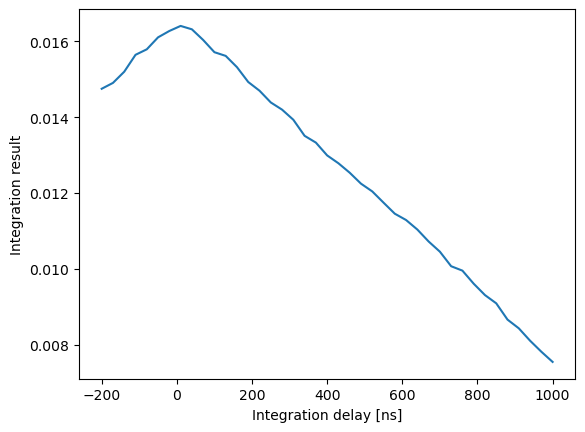

In [294]:
dat = prop_delay_results.get_data("res_prop_delay")
ax = prop_delay_results.get_axis("res_prop_delay")[0]

plt.plot(ax * 1e9, np.abs(dat))
plt.xlabel("Integration delay [ns]")
plt.ylabel("Integration result")
plt.show()

In [295]:
## Update readout parameters and set to calibration 

# measure_q.parameters.readout_integration_delay = ax[np.argmin(abs(dat))]
measure_q.parameters.readout_integration_delay = ax[np.argmax(abs(dat))]
print(measure_q.parameters.readout_integration_delay)

device_setup.set_calibration(
    measure_q.calibration()
)

9.999999999999984e-09


In [298]:
np.abs(dat)

array([0.01474957, 0.01490436, 0.01519912, 0.01564447, 0.01578969,
       0.01610521, 0.01627279, 0.01640633, 0.01631692, 0.0160363 ,
       0.01571344, 0.01561619, 0.01531894, 0.01492754, 0.01469842,
       0.01438878, 0.01419923, 0.01393252, 0.01350889, 0.01333036,
       0.01299256, 0.0127854 , 0.01253657, 0.01224828, 0.01204389,
       0.01174776, 0.01145606, 0.01128957, 0.01103862, 0.01072358,
       0.01045482, 0.01007115, 0.00995494, 0.00961025, 0.00931038,
       0.009093  , 0.00866363, 0.00843436, 0.00810804, 0.00781758,
       0.00754836])

### 3.5 Pulsed Qubit Spectroscopy

Find the resonance frequency of the qubit by looking at the change in resonator transmission when sweeping the frequency of a qubit excitation pulse

#### 3.5.1 Additional Experimental Parameters

Define the frequency scan and the pulses used in the experiment

In [195]:
# frequency range of spectroscopy scan - defined +/- expected qubit frequency as defined in qubit parameters
qspec_range = 50e6
# how many frequency points to measure
qspec_num = 1001

# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

In [203]:
### QB spec
# q_freq = 7.5847e9
q_freq = 5.7362*1e9

measure_q.parameters.drive_lo_frequency = 6e9
measure_q.parameters.resonance_frequency_ge = q_freq
measure_q.parameters.user_defined['amplitude_pi'] = 0.4

### RO spec
measure_q.parameters.readout_resonator_frequency = 6.8837e9
# measure_q.parameters.readout_range_out = -20
# measure_q.parameters.readout_range_in = -20
measure_q.parameters.user_defined['readout_amp'] = 0.9

measure_q.parameters.drive_range = -10
measure_q.parameters.user_defined['reset_length'] = 100e-6
measure_q.parameters.user_defined['pulse_length'] = 20e-6

print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5736200000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6883700000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=-10,
│   │   readout_range_out=-15,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.4,
│   │   │   'pulse_length': 2e-05,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [204]:
device_setup.set_calibration(
    measure_q.calibration()
)

#### 3.5.2 Experiment Definition

The frequency sweep of the drive line can now be done in real time (was: near time in older software releases)

In [205]:
# function that returns a qubit spectroscopy experiment- accepts frequency sweep range as parameter
def qubit_spectroscopy(freq_sweep, drive_pulse, readout_pulse, reset_delay):
    # Create qubit spectroscopy Experiment - uses qubit drive, readout drive and data acquisition lines
    exp_qspec = Experiment(
        uid="Qubit Spectroscopy",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    
    
    # inner loop - real-time averaging - QA in integration mode
    with exp_qspec.acquire_loop_rt(
        uid="freq_shots",
        count=2**num_averages,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        with exp_qspec.sweep(uid="qfreq_sweep", parameter=freq_sweep):
            # qubit drive
            with exp_qspec.section(uid="qubit_excitation"):
                # exp_qspec.play(signal="drive", pulse=drive_pulse)
                exp_qspec.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            with exp_qspec.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_qspec.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_qspec.acquire(
                    signal="acquire",
                    handle="qb_spec",
                    kernel=readout_pulse,
                )
            with exp_qspec.section(uid="delay"):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_qspec.delay(signal="measure", time=reset_delay)

    return exp_qspec

In [206]:
freq_sweep_q = create_drive_freq_sweep(measure_q, -qspec_range, qspec_range, qspec_num)

# experiment signal calibration for qubit, specifically overwriting the frequency to the sweep parameter
exp_calibration_q = Calibration()
exp_calibration_q["drive"] = SignalCalibration(
    oscillator=Oscillator(
        frequency=freq_sweep_q,
        modulation_type=ModulationType.HARDWARE,
    ),
)

#### 3.5.3 Run and Evaluate Experiment for Both Qubits

Runs the experiment and evaluates the data returned by the measurement

In [207]:
# define experiment with frequency sweep for qubit 0
drive_pulse = create_drive_spec_pulse(measure_q)

readout_pulse = create_readout_pulse(measure_q)

#update default calibration to qubit settings
device_setup.set_calibration(
    measure_q.calibration()
)

exp_qspec = qubit_spectroscopy(freq_sweep_q, drive_pulse, readout_pulse, reset_delay = measure_q.parameters.user_defined['reset_length'])

# apply calibration and signal map for qubit for this experiment
exp_qspec.set_calibration(exp_calibration_q)
exp_qspec.set_signal_map(signal_map_default(measure_q))

In [208]:
# compile the experiment on the open instrument session
compiled_qspec = session.compile(exp_qspec)

# Path("Pulse_Sheets").mkdir(parents=True, exist_ok=True)
# # generate a pulse sheet to inspect experiment before runtime
# show_pulse_sheet("Pulse_Sheets/Qubit_Spectroscopy", compiled_qspec)
# plot_simulation(compiled_qspec, 0, 500e-6)

[2024.06.13 16:36:42.293] INFO    Starting LabOne Q Compiler run...
[2024.06.13 16:36:42.396] INFO    Schedule completed. [0.101 s]
[2024.06.13 16:36:43.188] INFO    Code generation completed for all AWGs. [0.790 s]
[2024.06.13 16:36:43.190] INFO    Completed compilation step 1 of 1. [0.895 s]
[2024.06.13 16:36:43.193] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.13 16:36:43.195] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.06.13 16:36:43.196] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.13 16:36:43.197] INFO      device_shfqc        0         11            0           1      8000  
[2024.06.13 16:36:43.198] INFO      device_shfqc_sg     0         24            1           1     80000  
[2024.06.13 16:36:43.200] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.06.13 16:36:43.201] INFO      TOTAL                         35 

In [209]:
# run the experiment on qubit 0
qspec_results = session.run()

timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/qspec_results_{timestamp}.json")
print(f"File saved as Results_Needed/qspec_results_{timestamp}.json")

[2024.06.13 16:36:43.213] INFO    Configuring the device setup
[2024.06.13 16:36:43.316] INFO    The device setup is configured
[2024.06.13 16:36:44.715] INFO    Starting near-time execution...
[2024.06.13 16:36:45.305] INFO    Estimated RT execution time: 500.57 s.
[2024.06.13 16:45:06.126] INFO    Finished near-time execution.
File saved as Results_Needed/qspec_results_20240613T164506.json


estimated frequency 5.6915 GHz


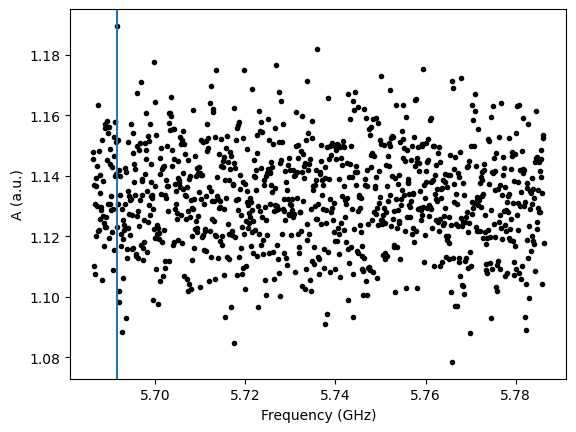

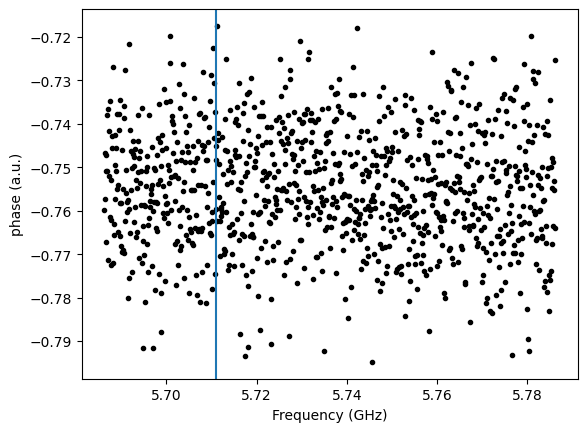

In [210]:
# get measurement data returned by the instruments
qspec_res = qspec_results.get_data("qb_spec")
# qspec_res-=qspec_res.mean()
qspec_freq = qspec_results.get_axis("qb_spec")[0] + measure_q.parameters.drive_lo_frequency

# if emulate:
#     # create some dummy data if running in emulation mode
#     qspec_res = lorentzian(
#         qspec_freq,
#         5e6,
#         measure_q.parameters.resonance_frequency_ge * (0.995 + 0.01 * np.random.rand(1)[0]),
#         -2e6,
#         1,
#     ) + 0.1 * np.random.rand(len(qspec_freq))


# plot measurement data
fig = plt.figure()
plt.plot(qspec_freq / 1e9, abs(qspec_res), ".k")
# plt.axvline(qspec_freq[np.argmax(abs(qspec_res))]/1e9)
plt.axvline(qspec_freq[np.argmax(abs(qspec_res))]/1e9)
# plt.axvline(5.750)
# plt.axvline(5.754)

plt.ylabel("A (a.u.)")
plt.xlabel("Frequency (GHz)")

fig = plt.figure()
plt.plot(qspec_freq / 1e9, np.unwrap(np.angle(qspec_res)), ".k")
plt.ylabel("phase (a.u.)")
plt.xlabel("Frequency (GHz)")

# plt.axvline(qspec_freq[np.argmax(abs(qspec_res))]/1e9, linestyle = '--')
# plt.axvline(4.567 , linestyle = '--')
print('estimated frequency ' + str(qspec_freq[np.argmax(abs(qspec_res))]/1e9) + ' GHz')
plt.axvline(qspec_freq[np.argmax(np.angle(qspec_res))]/1e9-0.0002)

plt.show()

In [469]:
qspec_freq[np.argmax(np.angle(qspec_res))]/1e9

5.737

In [107]:
device_setup.set_calibration(measure_q.calibration())

Do fitting and frequency update now if not in emulation mode:

Fitted parameters: [ 9.20064471e+03  4.00018795e+09 -1.99296387e+00  2.00000000e+00]


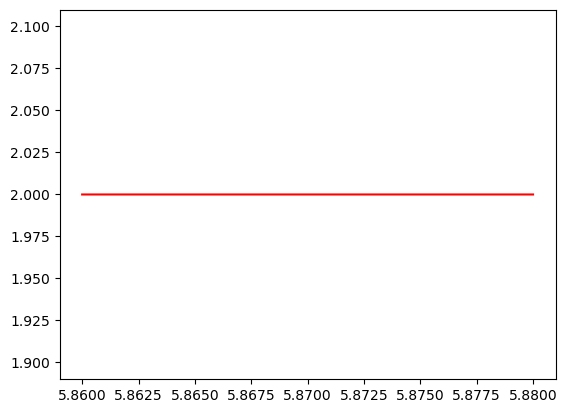

In [216]:
# update qubit parameters
if not emulate:
    # increase number of plot points for smooth plotting of fit reults
    freq_plot = np.linspace(qspec_freq[0], qspec_freq[-1], 5 * len(qspec_freq))
    
    # fit measurement data - here assuming an inverted Lorentzian response
    popt, pcov = lorentzian.fit(
        qspec_freq,
        abs(qspec_res),
        5e6,
        measure_q.parameters.resonance_frequency_ge,
        -1e6,
        1,
        plot=False,
        bounds=[[0, 4e9, -1e8, 0], [10e6, 6e9, 0, 2]],
    )
    print(f"Fitted parameters: {popt}")
    
    # plot fit results together with measurement data
    plt.plot(freq_plot / 1e9, lorentzian(freq_plot, *popt), "-r")
    
    measure_q.parameters.resonance_frequency_ge = popt[1]
    measure_q.parameters.resonance_frequency_ge

In [217]:
#simple min/max fit
measure_q.parameters.resonance_frequency_ge = qspec_freq[np.argmin(abs(qspec_res))]
print(f"Qubit Frequency: {measure_q.parameters.resonance_frequency_ge*1e-9} GHz")

device_setup.set_calibration(
    measure_q.calibration()
)

Qubit Frequency: 5.8670800000000005 GHz


### 3.6 Amplitude Rabi Experiment

Sweep the pulse amplitude of a qubit drive pulse to determine the ideal amplitudes for specific qubit rotation angles

#### 3.6.1 Additional Experimental Parameters

Define the amplitude sweep range and qubit excitation pulse

In [ ]:
# measure_q.parameters.readout_resonator_frequency=6881757000

In [472]:
qspec_freq[np.argmax(np.angle(qspec_res))]/1e9

5.737

In [493]:
measure_q.parameters.resonance_frequency_ge = 5.7368 *1e9 
# measure_q.parameters.user_defined['reset_length'] = 100e-6
# measure_q.parameters.user_defined['pulse_length'] = 2e-6
measure_q.parameters.drive_range = 1
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5736800000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6883900000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=1,
│   │   readout_range_out=-15,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.4,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [494]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 14

# define number of amplitude points, from 0 to 1 in gain
num_amplitudes = 50


#### 3.6.2 Experiment Definition

Define the experimental pulse and readout sequence - here without any explicit qubit reference

Explicit qubit reference is then given through different experimental calibration and signal maps

In [495]:
# function that returns an amplitude Rabi experiment


def amplitude_rabi(drive_pulse, readout_pulse, amplitude_sweep, relax_time = 1e-6):
    exp_rabi = Experiment(
        uid="Amplitude Rabi",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Rabi experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_rabi.acquire_loop_rt(
        uid="rabi_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
    ):
        
        # inner loop - real time sweep of Rabi ampitudes
        with exp_rabi.sweep(uid="rabi_sweep", parameter=amplitude_sweep):
            # play qubit excitation pulse - pulse amplitude is swept
            with exp_rabi.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_rabi.play(
                    signal="drive", pulse=drive_pulse, amplitude = amplitude_sweep, marker = {"marker1": {"enable": True}}
                )
            # readout pulse and data acquisition
            with exp_rabi.section(uid="readout_section", play_after="qubit_excitation"):
                # play readout pulse on measure line
                exp_rabi.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_rabi.acquire(
                    signal="acquire",
                    handle="amp_rabi",
                    kernel=readout_pulse,
                )
            with exp_rabi.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_rabi.reserve(signal="measure")
    return exp_rabi

#### 3.6.3 Set Experiment Parameters and Compile

In [496]:
# set signal map for qubit - no experimental calibration necessary, calibration taken from DeviceSetup, i.e. baseline
device_setup.set_calibration(
    measure_q.calibration()
)

drive_pulse = create_rabi_drive_pulse(measure_q)

exp_rabi = amplitude_rabi(
    drive_pulse, readout_pulse, create_rabi_amp_sweep(qubit=measure_q, amp_num=num_amplitudes), relax_time = measure_q.parameters.user_defined['reset_length']
)

exp_rabi.set_signal_map(signal_map_default(measure_q))

# compile the experiment on the open instrument session
compiled_rabi = session.compile(exp_rabi)

[2024.05.31 17:46:43.988] INFO    Starting LabOne Q Compiler run...
[2024.05.31 17:46:43.994] INFO    Schedule completed. [0.004 s]
[2024.05.31 17:46:44.039] INFO    Code generation completed for all AWGs. [0.042 s]
[2024.05.31 17:46:44.040] INFO    Completed compilation step 1 of 1. [0.050 s]
[2024.05.31 17:46:44.046] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:46:44.048] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.31 17:46:44.050] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:46:44.052] INFO      device_shfqc        0         11            0           1      8000  
[2024.05.31 17:46:44.053] INFO      device_shfqc_sg     0        158           50           1      8000  
[2024.05.31 17:46:44.055] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:46:44.056] INFO      TOTAL                        169 

#### 3.6.4 Show Pulse Sheet

In [497]:
show_pulse_sheet("Pulse_Sheets/Amplitude_Rabi", compiled_rabi)

[2024.05.31 17:46:49.898] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.05.31 17:46:49.901] INFO    Starting LabOne Q Compiler run...
[2024.05.31 17:46:49.912] INFO    Schedule completed. [0.008 s]
[2024.05.31 17:46:49.954] INFO    Code generation completed for all AWGs. [0.041 s]
[2024.05.31 17:46:49.955] INFO    Completed compilation step 1 of 1. [0.052 s]
[2024.05.31 17:46:49.957] INFO    Finished LabOne Q Compiler run.
[2024.05.31 17:46:49.971] INFO    Writing html file to Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Amplitude_Rabi_2024-05-31-17-46-49.html


Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Amplitude_Rabi_2024-05-31-17-46-49.html

#### 3.6.5 Plot Simulated Outputs

In [498]:
# Simulate experiment
# plot_simulation(compiled_rabi, 0e-6, 30e-6)

#### 3.6.6 Run, Save, and Plot Results

Finally, you'll run the experiment, save, and plot the results.

In [499]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5736800000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6883900000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=1,
│   │   readout_range_out=-15,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.4,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [500]:
# run the compiled experiemnt
rabi_results = session.run(compiled_rabi)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/rabi_results_{timestamp}.json")
print(f"File saved as Results_Needed/rabi_results_{timestamp}.json")

[2024.05.31 17:46:50.020] INFO    Configuring the device setup
[2024.05.31 17:46:50.122] INFO    The device setup is configured
[2024.05.31 17:46:50.989] WARNING SHFQC/SG:dev12237: Output channel 0 range 1.0 is not on the list of allowed ranges: [-30. -25. -20. -15. -10.  -5.   0.   5.  10.]. Nearest allowed range will be used.
[2024.05.31 17:46:50.994] INFO    Starting near-time execution...
[2024.05.31 17:46:51.487] INFO    Estimated RT execution time: 85.20 s.
[2024.05.31 17:48:16.918] INFO    Finished near-time execution.
File saved as Results_Needed/rabi_results_20240531T174817.json


In [501]:
# get measurement data returned by the instruments
rabi_res = rabi_results.get_data("amp_rabi")
# rabi_res-=rabi_res.mean()
rabi_abs = np.abs(rabi_res)
rabi_phase = np.unwrap(np.angle(rabi_res))
# define amplitude axis from qubit parameters
rabi_amp = rabi_results.get_axis("amp_rabi")[0]

if emulate:
    # create some dummy data if running in emulation mode
    rabi_res = oscillatory(rabi_amp, 10, 0, 1, 1.2) + 0.2 * np.random.rand(
        len(rabi_amp)
    )

Fitted parameters: [-12.40376616   3.43531785   0.04051243  -1.08593925]


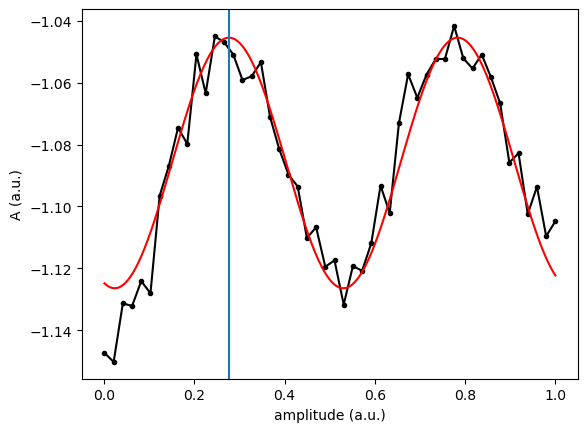

In [512]:
# plot measurement data
fig = plt.figure()
plt.plot(rabi_amp, rabi_phase,'.-' "k")
plt.ylabel("A (a.u.)")
plt.xlabel("amplitude (a.u.)")

# increase number of plot points for smooth plotting of fit results
amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))

# fit measurement results - assume sinusoidal oscillation with drive amplitude
popt, pcov = oscillatory.fit(rabi_amp, rabi_phase, -10, np.pi, 0.01, 3, plot=False)
print(f"Fitted parameters: {popt}")

# plot fit results together with measurement data
plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
pi_amp = -((popt[1]))/(popt[0])
plt.axvline(pi_amp)
# pi_amp = 0.95

In [513]:
pi_amp

0.2769576438979291

Fitted parameters: [ 8.88726895 -0.15311372 -0.04192564  3.07322386]


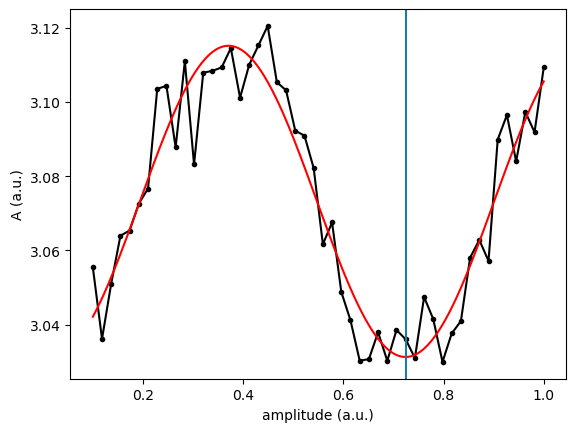

Fitted parameters: [ 9.17432701 -0.40230835 -0.03734093 -3.07315873]


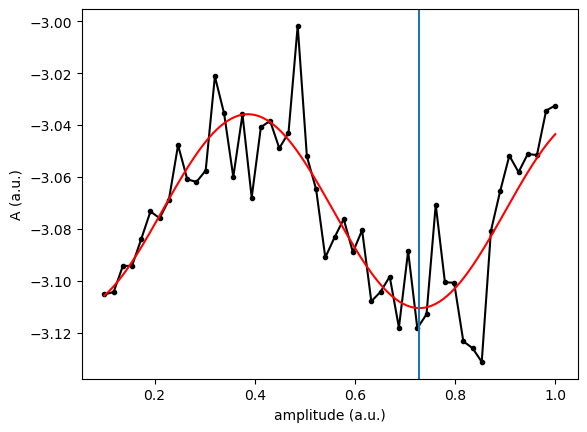

In [192]:
# 0.3 

Fitted parameters: [ 1.17277271e+01 -5.67851936e-02 -7.57809330e-03 -3.40873430e-04]
Fitted parameters: [ 1.24581630e+01 -3.16073514e-01 -4.43239007e-02  4.35703349e-04]


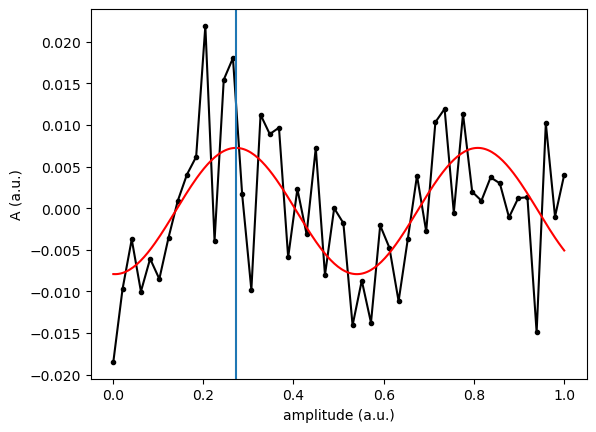

In [508]:
# plot measurement data
for data in [np.imag(rabi_res)-np.imag(rabi_res).mean(),np.real(rabi_res)-np.real(rabi_res).mean()]:
# for data in [np.real(rabi_res)-np.real(rabi_res).mean()]:

    fig = plt.figure()
    plt.plot(rabi_amp, data,'.-' "k")
    plt.ylabel("A (a.u.)")
    plt.xlabel("amplitude (a.u.)")
    
    # increase number of plot points for smooth plotting of fit results
    amp_plot = np.linspace(rabi_amp[0], rabi_amp[-1], 5 * len(rabi_amp))
    
    # fit measurement results - assume sinusoidal oscillation with drive amplitude
    popt, pcov = oscillatory.fit(rabi_amp, data, 10, 0, 1, 1.2, plot=False)
    print(f"Fitted parameters: {popt}")
    
    # plot fit results together with measurement data
    plt.plot(amp_plot, oscillatory(amp_plot, *popt), "-r");
    pi_amp = ((np.pi-popt[1]))/(popt[0])
    plt.axvline(pi_amp)
# pi_amp = 0.95

In [424]:
pi_amp 

0.43053169248894024

In [514]:
rabi_amplitude = pi_amp

measure_q.parameters.user_defined['amplitude_pi'] = rabi_amplitude

### 3.7 Ramsey Experiment
The Ramsey experiment is different from the experiments above as the length of the drive section changes. Using a right-aligned sweep section and the automatic repetition time makes sure that the experiment is run as efficiently as possible on the Zurich Instruments hardware.

#### 3.7.1 Experiment Parameters

In [463]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 11

# define delay sweep
n_steps = 201
start_delay = 0e-6
stop_delay = 6e-6


#### 3.7.2 Experiment Definition

In [464]:
# function that returns a Ramsey experiment


def ramsey(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_ramsey = Experiment(
        uid="Ramsey Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey.sweep(
            uid="ramsey_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey.delay(signal="drive", time=time_sweep)
                exp_ramsey.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey.reserve(signal="measure")
    return exp_ramsey

In [465]:
#measure_q.parameters.user_defined['reset_length'] = 1e-3
# measure_q.parameters.resonance_frequency_ge = 3.75512e9+1e6
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5751776418.066025,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6884818162.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=-10,
│   │   readout_range_out=0,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.4,
│   │   │   'pulse_length': 3e-07,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.4,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

#### 3.7.3 Create Experiment and Signal Map

In [466]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_ramsey_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

ramsey_exp = ramsey(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

ramsey_exp.set_signal_map(signal_map_default(measure_q))

compiled_ramsey = session.compile(ramsey_exp)

[2024.05.17 16:45:28.217] INFO    Starting LabOne Q Compiler run...
[2024.05.17 16:45:28.241] INFO    Schedule completed. [0.022 s]
[2024.05.17 16:45:28.560] INFO    Code generation completed for all AWGs. [0.321 s]
[2024.05.17 16:45:28.560] INFO    Completed compilation step 1 of 1. [0.347 s]
[2024.05.17 16:45:28.567] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.17 16:45:28.567] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.17 16:45:28.567] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.17 16:45:28.567] INFO      device_shfqc        0        809            0           1      8000  
[2024.05.17 16:45:28.567] INFO      device_shfqc_sg     0       1025            6           6      8608  
[2024.05.17 16:45:28.567] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.17 16:45:28.577] INFO      TOTAL                       1834 

#### 3.7.4 Show Pulse Sheet

In [467]:
show_pulse_sheet("Pulse_Sheets/Ramsey", compiled_ramsey)

[2024.05.17 16:45:28.587] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.05.17 16:45:28.587] INFO    Starting LabOne Q Compiler run...
[2024.05.17 16:45:28.625] INFO    Schedule completed. [0.033 s]
[2024.05.17 16:45:28.850] INFO    Code generation completed for all AWGs. [0.226 s]
[2024.05.17 16:45:28.850] INFO    Completed compilation step 1 of 1. [0.264 s]
[2024.05.17 16:45:28.850] INFO    Finished LabOne Q Compiler run.
[2024.05.17 16:45:28.867] INFO    Writing html file to Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Ramsey_2024-05-17-16-45-28.html


Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\Ramsey_2024-05-17-16-45-28.html

#### 3.7.5 Plot Simulated Outputs

In [468]:
# plot_simulation(compiled_ramsey, 50e-6, 100e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [469]:
# run the compiled experiemnt
ramsey_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/ramsey_results_{timestamp}_.json")
print(f"File saved as Results/ramsey_results_{timestamp}_.json")

[2024.05.17 16:45:28.915] INFO    Configuring the device setup
[2024.05.17 16:45:29.017] INFO    The device setup is configured
[2024.05.17 16:45:30.068] INFO    Starting near-time execution...
[2024.05.17 16:45:30.637] INFO    Estimated RT execution time: 43.47 s.
[2024.05.17 16:46:14.354] INFO    Finished near-time execution.
File saved as Results/ramsey_results_20240517T164614_.json


In [470]:
# get measurement data returned by the instruments
ramsey_res = ramsey_results.get_data("ramsey")
ramsey_imag = np.imag(ramsey_res)
# define time axis from qubit parameters
ramsey_delay = ramsey_results.get_axis("ramsey")[0]

if emulate:
    # create dummy data if running in emulation mode
    ramsey_res = oscillatory_decay(
        ramsey_delay, 1e6, 0, 1 / 10e-6, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(ramsey_delay))

In [471]:
# get measurement data returned by the instruments
data_raw=ramsey_results.get_data("ramsey")*np.exp(1j*np.pi/2)
data_raw-=data_raw.mean()


Fitted parameters: [ 4.69813383e+05 -6.62532772e-02  4.85461254e+05 -1.22763438e-01
  2.48056047e-02]
T_2R = 2.059896626599586 us
Detuning = 0.07477312227161442 MHz


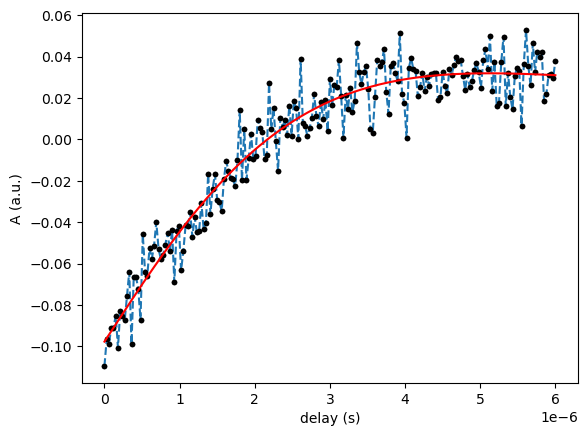

Fitted parameters: [ 8.39915617e+01  5.96346793e-01  5.04541190e+05  4.36601935e-02
 -1.13917165e-02]
T_2R = 1.9819987357600188 us
Detuning = 1.336767221616984e-05 MHz


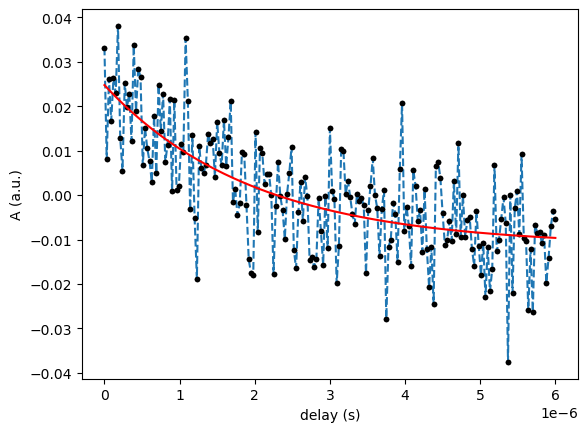

In [475]:
# plot measurement results

for data in [np.imag(data_raw),np.real(data_raw)]:
    fig = plt.figure()
    plt.plot(ramsey_delay, (data), ".k")
    plt.plot(ramsey_delay, (data), linestyle ='--')
    
    plt.ylabel("A (a.u.)")
    plt.xlabel("delay (s)")
    
    # increase number of plot points for smooth plotting of fit results
    delay_plot = np.linspace(ramsey_delay[0], ramsey_delay[-1], 5 * len(ramsey_delay))
    
    ## fit measurement data to decaying sinusoidal oscillatio
    popt, pcov = oscillatory_decay.fit(
        ramsey_delay,
        (data),
        1/5e-6,
        0,
        1 / 10e-6,
        0.002,
        0.0008,
        plot=True,
        # bounds=[
        #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
        #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
        # ],
    )
    print(f"Fitted parameters: {popt}")
    print(f"T_2R = {1e6/popt[2]} us")
    print(f"Detuning = {popt[0]/2/np.pi/1e6} MHz")
    plt.show()

Fitted parameters: [ 1.32171951e+07 -2.07643527e+01  6.04427246e+05 -1.07800464e-01
  1.17256635e-03]


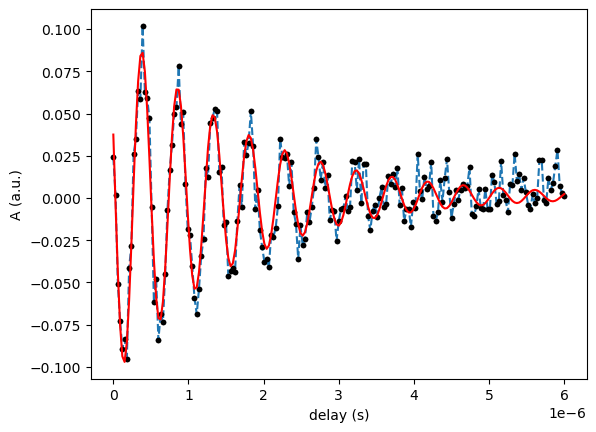

Fitted parameters: [ 1.39429076e+06 -1.23498360e+00  4.35702728e+04  2.68799059e-03
 -4.89664240e-04]


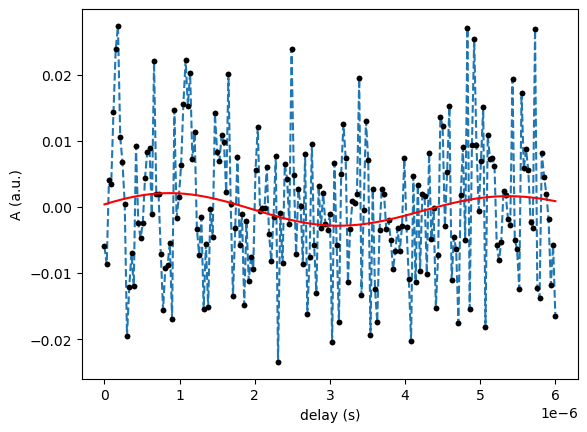

Fitted parameters: [ 1.57575242e+06 -2.54343653e+00  6.84677566e+05  1.48427897e-01
 -2.42930200e-03]


Fitted parameters: [-1.51833579e+06 -3.81840300e+00  7.03858586e+05 -5.49770823e-02
  1.19787563e-03]


In [440]:
 1.32171951e+07/2/np.pi/1e6

2.103581933974978

In [438]:
oscillatory_decay?

Signature:
oscillatory_decay(
    x: 'ArrayLike',
    frequency: 'float',
    phase: 'float',
    decay_rate: 'float',
    amplitude: 'float' = 1.0,
    offset: 'float' = 0.0,
) -> 'ArrayLike'
Docstring:
A function for modelling decaying oscillations such as Ramsey
decay.

The form of the function is a decaying cosine:

$$
    f(x) = amplitude \times \cos(frequency \times x + phase)
           \exp(-decay \text{\textunderscore} rate \times x) + offset
$$

Calling this function evaluates it. One may also fit this function
by calling `oscillatory_decay.fit` which calls
[fit][laboneq.analysis.fitting.fit] with this function.

Arguments:
    x:
        An array of values to evaluate the function at.
    frequency:
        The frequency of the cosine.
    phase:
        The phase of the cosine.
    decay_rate:
        The exponential decay rate.
    amplitude:
        The amplitude of the cosine.
    offset:
        The offset of the function.

Returns:
    values:
        The values of the

### Ramsey Heralded

In [ ]:
# function that returns a Ramsey experiment


def ramsey_herald(drive_pulse, readout_pulse, time_sweep, num_averages = 8, relax_time = 5e-6):
    exp_ramsey_herald = Experiment(
        uid="Ramsey Experiment_herald",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Ramsey experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_ramsey_herald.acquire_loop_rt(
        uid="ramsey_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.SINGLE_SHOT,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of Ramsey time delays
        with exp_ramsey_herald.sweep(
            uid="ramsey_sweep_herald", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            with exp_ramsey_herald.section(
                uid="readout_section_herald"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey_herald",
                    kernel=readout_pulse,
                )
            
            # play qubit excitation pulse - pulse delay is swept
            with exp_ramsey_herald.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT, play_after="readout_section_herald"
            ):
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_ramsey_herald.delay(signal="drive", time=time_sweep)
                exp_ramsey_herald.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_ramsey_herald.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_ramsey_herald.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_ramsey_herald.acquire(
                    signal="acquire",
                    handle="ramsey",
                    kernel=readout_pulse,
                )
            with exp_ramsey_herald.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_ramsey_herald.reserve(signal="measure")
    return exp_ramsey_herald

### 3.8 T1 Experiment
The T1 experiment is different from the Ramsey by a single line.

#### 3.7.1 Experiment Parameters

In [515]:
pi_amp

0.2769576438979291

In [309]:
measure_q.parameters.user_defined['amplitude_pi'] = pi_amp
# measure_q.parameters.user_defined['pulse_length'] = 20e-6
# measure_q.parameters.drive_range = 10

In [516]:
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5736800000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6883900000.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=1,
│   │   readout_range_out=-15,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.2769576438979291,
│   │   │   'pulse_length': 2e-06,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.9,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

In [525]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

# define delay sweep
n_steps = 50
start_delay = 0e-6
stop_delay = 10e-6


#### 3.7.2 Experiment Definition

In [526]:
# function that returns a T1 experiment


def T1(drive_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_T1 = Experiment(
        uid="T1 Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define T1 experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_T1.acquire_loop_rt(
        uid="T1_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
        
        # inner loop - real time sweep of T1 time delays
        with exp_T1.sweep(
            uid="T1_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse - delay is swept
            with exp_T1.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_T1.play(signal="drive", pulse=drive_pulse, marker = {"marker1": {"enable": True}})
                exp_T1.delay(signal="drive", time=time_sweep)
            # readout pulse and data acquisition
            with exp_T1.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_T1.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_T1.acquire(
                    signal="acquire",
                    handle="T1",
                    kernel=readout_pulse,
                )
            with exp_T1.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_T1.reserve(signal="measure")
    return exp_T1

#### 3.7.3 Create Experiment and Signal Map

In [527]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
drive_pulse = create_T1_drive_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

T1_exp = T1(
    drive_pulse=drive_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

T1_exp.set_signal_map(signal_map_default(measure_q))

compiled_T1 = session.compile(T1_exp)

[2024.05.31 17:53:31.632] INFO    Starting LabOne Q Compiler run...
[2024.05.31 17:53:31.642] INFO    Schedule completed. [0.007 s]
[2024.05.31 17:53:31.694] INFO    Code generation completed for all AWGs. [0.050 s]
[2024.05.31 17:53:31.696] INFO    Completed compilation step 1 of 1. [0.061 s]
[2024.05.31 17:53:31.702] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:53:31.704] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.31 17:53:31.706] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:53:31.708] INFO      device_shfqc        0        205            0           1      8000  
[2024.05.31 17:53:31.710] INFO      device_shfqc_sg     0        203           16          16    128480  
[2024.05.31 17:53:31.712] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.31 17:53:31.713] INFO      TOTAL                        408 

#### 3.7.4 Show Pulse Sheet

In [528]:
show_pulse_sheet("Pulse_Sheets/T1", compiled_T1)

[2024.05.31 17:53:31.730] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.05.31 17:53:31.734] INFO    Starting LabOne Q Compiler run...
[2024.05.31 17:53:31.752] INFO    Schedule completed. [0.016 s]
[2024.05.31 17:53:31.797] INFO    Code generation completed for all AWGs. [0.043 s]
[2024.05.31 17:53:31.800] INFO    Completed compilation step 1 of 1. [0.063 s]
[2024.05.31 17:53:31.802] INFO    Finished LabOne Q Compiler run.
[2024.05.31 17:53:31.817] INFO    Writing html file to Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\T1_2024-05-31-17-53-31.html


Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\T1_2024-05-31-17-53-31.html

#### 3.7.5 Plot Simulated Outputs

In [529]:
# plot_simulation(compiled_T1, 100e-6, 150e-6, plot_width=10)

#### 3.7.6 Run, Save, and Plot Results

In [530]:
# run the compiled experiemnt
T1_results = session.run(compiled_T1)
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results_Needed").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results_Needed/T1_results_{timestamp}.json")
print(f"File saved as Results_Needed/T1_results_{timestamp}.json")

[2024.05.31 17:53:38.911] INFO    Configuring the device setup
[2024.05.31 17:53:39.025] INFO    The device setup is configured
[2024.05.31 17:53:40.210] WARNING SHFQC/SG:dev12237: Output channel 0 range 1.0 is not on the list of allowed ranges: [-30. -25. -20. -15. -10.  -5.   0.   5.  10.]. Nearest allowed range will be used.
[2024.05.31 17:53:40.220] INFO    Starting near-time execution...
[2024.05.31 17:53:40.768] INFO    Estimated RT execution time: 22.32 s.
[2024.05.31 17:54:03.356] INFO    Finished near-time execution.
File saved as Results_Needed/T1_results_20240531T175403.json


In [531]:
# get measurement data returned by the instruments
data=T1_results.get_data("T1")*np.exp(1j*np.pi/2)
data-=data.mean()

T1_real = np.real(data)
T1_imag = np.imag(data)
# define time axis from qubit parameters
T1_delay = T1_results.get_axis("T1")[0]

if emulate:
    # create dummy data if running in emulation mode
    T1_res = exponential_decay(
        T1_delay, 2e5, amplitude=0.5, offset=0.5
    ) + 0.12 * np.random.rand(len(T1_delay))

In [535]:
# plot measurement results
fig = plt.figure()
# plt.plot(T1_delay, T1_real, ".b")
# plt.ylabel("mag (a.u.)")
# plt.xlabel("delay (us)")

## fit measurement data to decaying sinusoidal oscillatio
# popt, pcov = exponential_decay.fit(
#    T1_delay,
#    -T1_real,
#    1/300e-6,
#    0.005,
#    0.005,
#    plot=False,
# )
# print(f"Fitted parameters: {popt}")
# print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

plt.show()
plt.plot(T1_delay, T1_imag, ".g")
plt.ylabel("phase (a.u.)")
plt.xlabel("delay (s)")

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_imag,
   1/30e-6,
   0.005,
   0.005,
   plot=True,
)
plt.title('T1 time ' + str(1/popt[0]*1e6) + ' us')
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

<Figure size 640x480 with 0 Axes>

Fitted parameters: [ 3.74185858e+05 -2.56280697e-02  9.63267221e-02]
T1 time 2.6724687194017362 us


Fitted parameters: [ 4.75675646e+04 -1.79949706e-02  8.38931809e-02]
T1 time 21.022728570214102 us


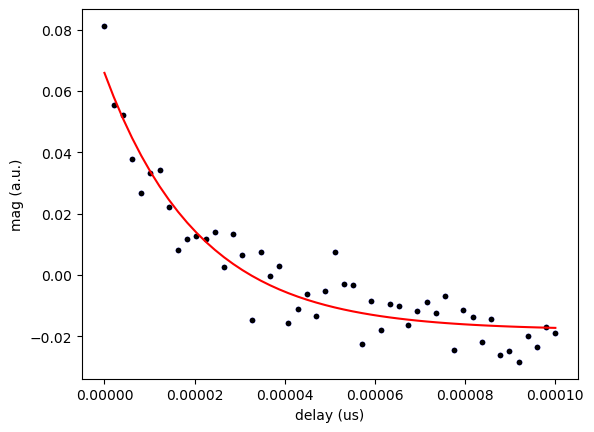

In [327]:
# plot measurement results
fig = plt.figure()
plt.plot(T1_delay, T1_real, ".b")
plt.ylabel("mag (a.u.)")
plt.xlabel("delay (us)")

## fit measurement data to decaying sinusoidal oscillatio
# popt, pcov = exponential_decay.fit(
#    T1_delay,
#    -T1_real,
#    1/300e-6,
#    0.005,
#    0.005,
#    plot=False,
# )
# print(f"Fitted parameters: {popt}")
# print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

# plt.show()
# plt.plot(T1_delay, T1_imag, ".g")
# plt.ylabel("phase (a.u.)")
# plt.xlabel("delay (s)")
## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = exponential_decay.fit(
   T1_delay,
   T1_real,
   1/30e-6,
   0.005,
   0.005,
   plot=True,
)
print(f"Fitted parameters: {popt}")
print('T1 time ' + str(1/popt[0]*1e6) + ' us') 

In [205]:
# import sys
# import os, pickle
# data_dictionary = {"time(s)" : T1_delay, 
#                    "phase_rad" : (-T1_res), }
# measurement_name = "T1"

# data_dir = r"Z:\projects\2023-3DMQ\ICP240422\240503"

# filename = os.path.join(fr"{data_dir}\{measurement_name}.pickle")
# if True:
#     with open(filename,'wb') as f:
#         pickle.dump(data_dictionary, f)

#     fig.savefig(filename.split(".pickle")[0] + ".png", dpi=300, bbox_inches="tight", pad_inches=0)

### 3.9 echo Experiment
Adding a Y180 pulse in middle of Ramsey

In [373]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 12

# define delay sweep
n_steps = 101
start_delay = 0e-6
stop_delay = 50e-6


#### 3.9.2 Experiment Definition

In [374]:
# function that returns an Echo experiment


def echo(x90_pulse, y180_pulse, readout_pulse, time_sweep, relax_time = 5e-6):
    exp_echo = Experiment(
        uid="Echo Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define Echo experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_echo.acquire_loop_rt(
        uid="echo_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # inner loop - real time sweep of echo time delays
        with exp_echo.sweep(
            uid="echo_sweep", parameter=time_sweep, alignment=SectionAlignment.RIGHT
        ):
            # play qubit excitation pulse
            with exp_echo.section(
                uid="qubit_excitation", alignment=SectionAlignment.RIGHT
            ):
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=y180_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_echo.delay(signal="drive", time=time_sweep/2)
                exp_echo.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_echo.section(
                uid="readout_section", play_after="qubit_excitation"
            ):
                # play readout pulse on measure line
                exp_echo.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_echo.acquire(
                    signal="acquire",
                    handle="echo",
                    kernel=readout_pulse,
                )
            with exp_echo.section(uid="delay", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_echo.reserve(signal="measure")
    return exp_echo

In [375]:
# measure_q.parameters.resonance_frequency_ge = 4.5509e9+190e3
# measure_q.parameters.user_defined['reset_length'] = 5e-3
print(measure_q)

Transmon(
│   uid='q0',
│   signals={'drive': '/logical_signal_groups/q0/drive_line', 'measure': '/logical_signal_groups/q0/measure_line', 'acquire': '/logical_signal_groups/q0/acquire_line'},
│   parameters=TransmonParameters(
│   │   resonance_frequency_ge=5753880000.0,
│   │   resonance_frequency_ef=2950000000.0,
│   │   drive_lo_frequency=6000000000.0,
│   │   readout_resonator_frequency=6884818162.0,
│   │   readout_lo_frequency=7000000000.0,
│   │   readout_integration_delay=0,
│   │   drive_range=-15,
│   │   readout_range_out=-5,
│   │   readout_range_in=0,
│   │   flux_offset_voltage=0,
│   │   user_defined={
│   │   │   'amplitude_pi': 0.42904506506209583,
│   │   │   'pulse_length': 3e-07,
│   │   │   'readout_len': 2e-06,
│   │   │   'readout_amp': 0.4,
│   │   │   'reset_length': 0.0001
│   │   }
│   )
)

#### 3.9.3 Create Experiment and Signal Map

In [376]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
time_sweep = create_delay_sweep(start=start_delay, stop=stop_delay, count=n_steps)

#update calibration to default
device_setup.set_calibration(
    measure_q.calibration()
)

echo_exp = echo(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, time_sweep=time_sweep, relax_time = measure_q.parameters.user_defined['reset_length']
)

echo_exp.set_signal_map(signal_map_default(measure_q))

compiled_echo = session.compile(echo_exp)

[2024.05.16 18:49:32.902] INFO    Starting LabOne Q Compiler run...
[2024.05.16 18:49:32.919] INFO    Schedule completed. [0.014 s]
[2024.05.16 18:49:33.037] INFO    Code generation completed for all AWGs. [0.116 s]
[2024.05.16 18:49:33.038] INFO    Completed compilation step 1 of 1. [0.133 s]
[2024.05.16 18:49:33.041] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.16 18:49:33.043] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2024.05.16 18:49:33.044] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.16 18:49:33.045] INFO      device_shfqc        0        409            0           1      8000  
[2024.05.16 18:49:33.046] INFO      device_shfqc_sg     0        730            7           7      9728  
[2024.05.16 18:49:33.048] INFO     ───────────────────────────────────────────────────────────────────── 
[2024.05.16 18:49:33.049] INFO      TOTAL                       1139 

#### 3.9.4 Show Pulse Sheet

In [377]:
show_pulse_sheet("Pulse_Sheets/echo", compiled_echo)

[2024.05.16 18:49:33.060] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2024.05.16 18:49:33.063] INFO    Starting LabOne Q Compiler run...
[2024.05.16 18:49:33.083] INFO    Schedule completed. [0.017 s]
[2024.05.16 18:49:33.204] INFO    Code generation completed for all AWGs. [0.120 s]
[2024.05.16 18:49:33.206] INFO    Completed compilation step 1 of 1. [0.141 s]
[2024.05.16 18:49:33.208] INFO    Finished LabOne Q Compiler run.
[2024.05.16 18:49:33.223] INFO    Writing html file to Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\echo_2024-05-16-18-49-33.html


Z:\projects\2024-two_Kerr-Cats\Pulse_Sheets\echo_2024-05-16-18-49-33.html

#### 3.9.5 Plot Simulated Outputs

In [378]:
# plot_simulation(compiled_echo, 4000e-6, 4050e-6, plot_width=10)

#### 3.9.6 Run, Save, and Plot Results

In [379]:
# run the compiled experiemnt
echo_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/echo_results_{timestamp}.json")
print(f"File saved as Results/echo_results_{timestamp}.json")

[2024.05.16 18:49:33.264] INFO    Configuring the device setup
[2024.05.16 18:49:33.375] INFO    The device setup is configured
[2024.05.16 18:49:34.461] INFO    Starting near-time execution...
[2024.05.16 18:49:34.960] INFO    Estimated RT execution time: 52.91 s.
[2024.05.16 18:50:28.130] INFO    Finished near-time execution.
File saved as Results/echo_results_20240516T185028.json


In [380]:
# get measurement data returned by the instruments
echo_real = np.real(echo_results.get_data("echo"))
echo_imag =  np.imag(echo_results.get_data("echo"))
echo_res = echo_real
# define time axis from qubit parameters
echo_delay = echo_results.get_axis("echo")[0]


Fitted parameters: [ 1.90514569e+05 -1.31592294e+00  1.39341644e-01]
T2 Echo time 5.248942407264672 us


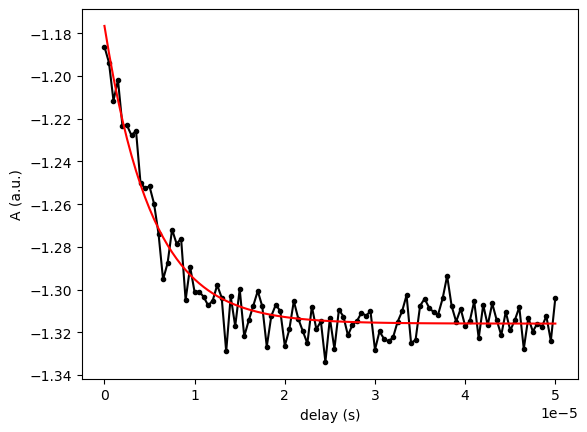

In [381]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
# plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

popt, pcov = exponential_decay.fit(
   echo_delay[:],
   echo_res[:],
   1/100e-6,
   0.005,
   0.005,
   plot=True,
   # bounds=[
   #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
   #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
   # ],
)
print(f"Fitted parameters: {popt}")
print('T2 Echo time ' + str(1/popt[0]*1e6) + ' us') 

## fit measurement data to decaying sinusoidal oscillatio
# popt, pcov = oscillatory_decay.fit(
#     echo_delay[:50],
#     echo_res[:50],
#     1e6,
#     0,
#     2 / 1 / 100e-6,
#     0.05,
#     0.05,
#     plot=True,
#     # bounds=[
#     #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
#     #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
#     # ],
# )
# print(f"Fitted parameters: {popt}")

Fitted parameters: [ 9.02729410e+07 -2.68053413e-01 -2.90896426e-02]
T2 Echo time 0.01107751656929392 us


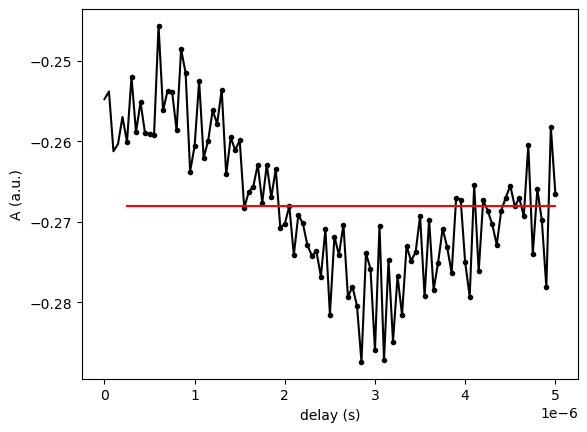

In [ ]:
exponential_decay?

In [493]:
(1/1.89703750e+04)/1e-6

52.71377081370295

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

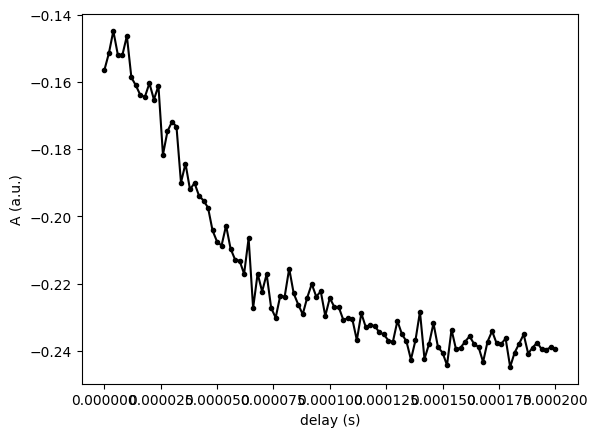

In [494]:
# plot measurement results (XXX) 5 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel(r"delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 100e-6,
    0.05,
    0.05,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [536]:
(1/3.6254e+03)/1e-6

275.8316323716004

Fitted parameters: [ 2.17199977e+00 -1.55100468e+00  1.35022399e+04 -1.12213537e-02
  3.55118684e-04]


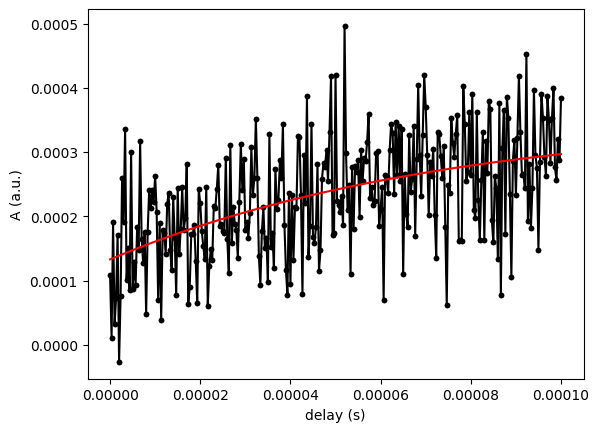

In [498]:
# plot measurement results (XXX) 2 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

Fitted parameters: [-9.96124680e-01 -1.54742321e+00  4.68931800e+04 -7.52474495e-03
  2.84832973e-04]


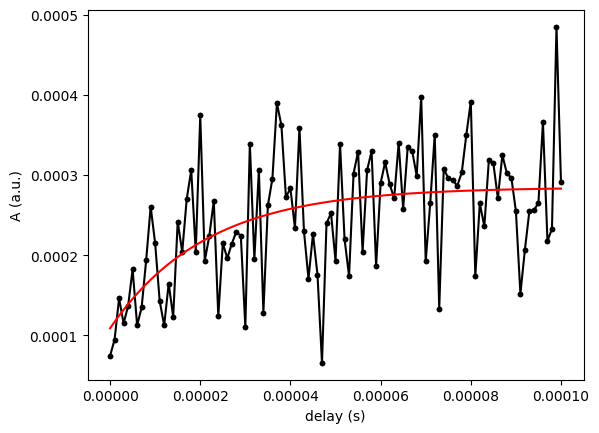

In [462]:
# plot measurement results (XXX) 2 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [454]:
# plot measurement results (XXX) 2 ms reset
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

Fitted parameters: [6.91906851e+02 7.85580960e+00 9.72198267e+04 4.89938676e-02
 2.74900929e-04]


In [455]:
1/9.72198267e+04

1.0285967728432496e-05

Fitted parameters: [-2.87629676e+01 -1.55217762e+00  1.43721174e+03 -3.01599994e-02
  7.17638142e-04]


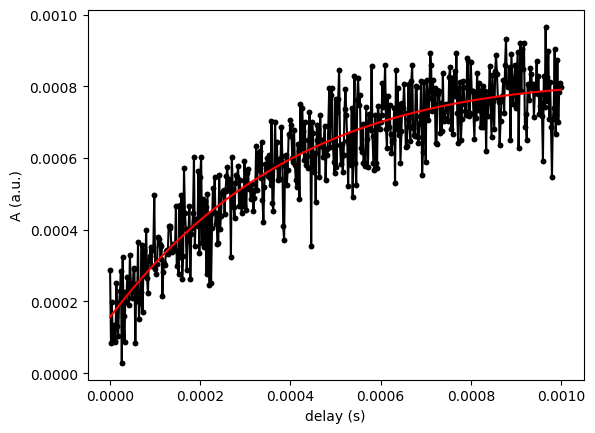

In [445]:
# plot measurement results (XXX)
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [447]:
(1/1.43721174e+03)*1e6

695.7917001151133

Fitted parameters: [ 1.25663717e+06  1.54091687e+00  3.23515577e+03 -2.05977841e-02
  7.85209014e-04]


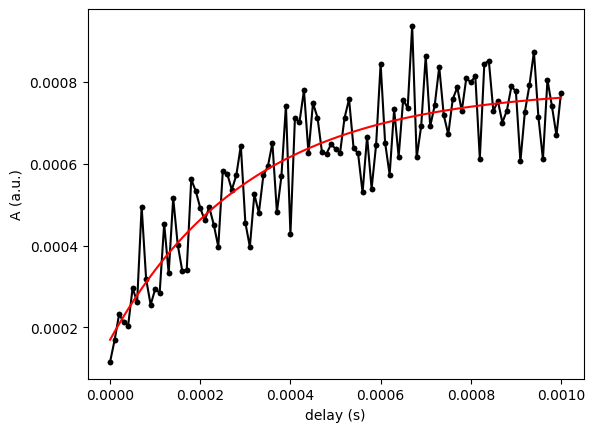

In [438]:
# plot measurement results (XXX) -100 kHZ
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [511]:
1/3.23515577e+03

0.00030910412700158794

Fitted parameters: [ 1.25663706e+06  1.53908113e+00  2.90669886e+03 -2.05630847e-02
  8.06758890e-04]


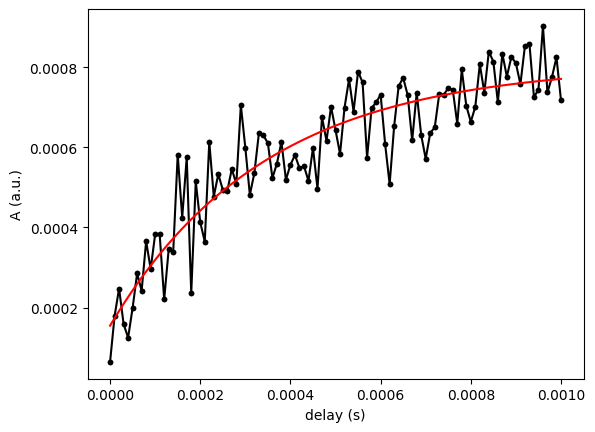

In [433]:
# plot measurement results (XXX) -10 kHZ
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

In [428]:
# plot measurement results (XXX) +10 kHZ
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

Fitted parameters: [ 1.25653209e+06  1.53641424e+00  5.71083452e+03 -1.94497706e-02
  7.59765522e-04]


In [423]:
# plot measurement results (XYX) +10 kHZ
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

Fitted parameters: [1.25663706e+06 1.52905051e+00 1.89577278e+03 1.73858115e-02
 7.50606117e-04]


In [512]:
1/1.89577278e+03

0.0005274893755991158

Fitted parameters: [1.25656031e+06 1.54643143e+00 4.13951735e+03 2.49213366e-02
 8.24184824e-04]


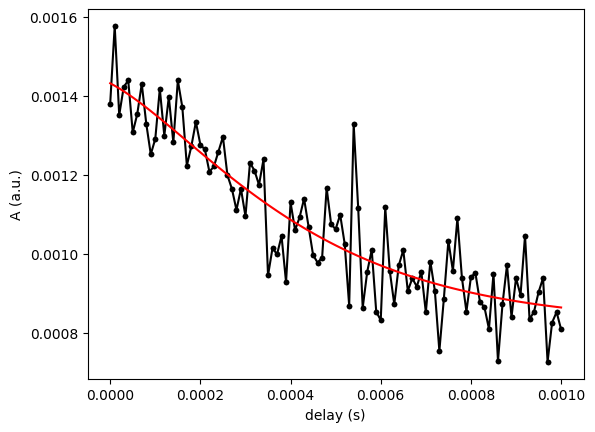

In [417]:
# plot measurement results (XYX)
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

In [ ]:
Fitted parameters: [6.32705958e+04 1.74914151e-01 1.69612154e+04 1.55160184e-03
 1.79806779e-03]

In [410]:
# plot measurement results (XXX)
fig = plt.figure()
plt.plot(echo_delay, echo_res, "k")
plt.plot(echo_delay, echo_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("delay (s)")

# increase number of plot points for smooth plotting of fit results
delay_plot = np.linspace(echo_delay[0], echo_delay[-1], 5 * len(echo_delay))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    echo_delay,
    echo_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=True,
    # bounds=[
    #     [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
    #     [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    # ],
)
print(f"Fitted parameters: {popt}")

# plot fit results together with experimental data
#plt.plot(delay_plot, oscillatory_decay(delay_plot, *popt), "-r");

Fitted parameters: [ 1.25663705e+06  1.54246935e+00  2.47660273e+03 -2.65850856e-02
  8.68922471e-04]


C:\Users\QNL\Anaconda2\envs\LabOneQ\lib\site-packages\laboneq\analysis\fitting.py:203: RuntimeWarning: overflow encountered in exp
  return amplitude * np.cos(frequency * x + phase) * np.exp(-decay_rate * x) + offset


In [411]:
1/ 2.47660273e+03

0.0004037789298568689

In [418]:
1/4.13951735e+03

0.0002415740569368552

### 3.10 CPMG Experiment
Adding a multiple Y180 pulse into echo

In [81]:
# define number of averages
# used for 2^num_averages, maximum: num_averages = 17
num_averages = 4

# define number of Y180 pulses
n_steps = 6
# define time between Y180 pulses
tau = 100e-9


#### 3.10.2 Experiment Definition

In [82]:
# function that returns an CPMG experiment


def cpmg(x90_pulse, y180_pulse, readout_pulse, tau, pulse_sweep, relax_time = 5e-6):
    exp_cpmg = Experiment(
        uid="cpmg Experiment",
        signals=[
            ExperimentSignal("drive"),
            ExperimentSignal("measure"),
            ExperimentSignal("acquire"),
        ],
    )

    ## define cpmg experiment pulse sequence
    # outer loop - real-time, cyclic averaging
    with exp_cpmg.acquire_loop_rt(
        uid="cpmg_shots",
        count=2**num_averages,
        averaging_mode=AveragingMode.CYCLIC,
        acquisition_type=AcquisitionType.INTEGRATION,
        #repetition_mode=RepetitionMode.AUTO,
    ):
            
        # loop through pulse count, always starts at one Y180 pulse
        for N in pulse_sweep:
            # play qubit excitation pulse
            with exp_cpmg.section(
                uid=f"qubit_excitation{N}", alignment=SectionAlignment.RIGHT
            ):
                exp_cpmg.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
                exp_cpmg.delay(signal="drive", time=tau/2)
                for i in range(N-1):
                    exp_cpmg.play(signal="drive", pulse=y180_pulse, phase = np.pi/2, marker = {"marker1": {"enable": True}})
                    exp_cpmg.delay(signal="drive", time=tau)
                exp_cpmg.play(signal="drive", pulse=y180_pulse, phase = np.pi/2, marker = {"marker1": {"enable": True}})
                exp_cpmg.delay(signal="drive", time=tau/2)
                exp_cpmg.play(signal="drive", pulse=x90_pulse, phase = 0, marker = {"marker1": {"enable": True}})
            # readout pulse and data acquisition
            with exp_cpmg.section(
                uid=f"readout_section{N}", play_after=f"qubit_excitation{N}"
            ):
                # play readout pulse on measure line
                exp_cpmg.play(signal="measure", pulse=readout_pulse)
                # trigger signal data acquisition
                exp_cpmg.acquire(
                    signal="acquire",
                    handle="cpmg",
                    kernel=readout_pulse,
                )
            with exp_cpmg.section(uid=f"delay{N}", length=relax_time):
                # relax time after readout - for qubit relaxation to groundstate and signal processing
                exp_cpmg.reserve(signal="measure")
                exp_cpmg.reserve(signal="drive")
                exp_cpmg.reserve(signal="acquire")
    return exp_cpmg

#### 3.10.3 Create Experiment and Signal Map

In [83]:
# define pulses and create experiment
readout_pulse = create_readout_pulse(measure_q)
x90_pulse = create_pi_2_pulse(measure_q)
y180_pulse = create_pi_pulse(measure_q)
pulse_sweep = np.linspace(1,n_steps,n_steps).astype('int')


cpmg_exp = cpmg(
    x90_pulse=x90_pulse, y180_pulse=y180_pulse, readout_pulse=readout_pulse, pulse_sweep=pulse_sweep, tau=tau, relax_time = measure_q.parameters.user_defined['reset_length']
)

cpmg_exp.set_signal_map(signal_map_default(measure_q))

compiled_cpmg = session.compile(cpmg_exp)

[2023.11.30 15:25:16.940] INFO    Starting LabOne Q Compiler run...
[2023.11.30 15:25:16.970] INFO    Schedule completed
[2023.11.30 15:25:17.165] INFO     ───────────────────────────────────────────────────────────────────── 
[2023.11.30 15:25:17.170] INFO      Device            AWG   SeqC LOC   CT entries   Waveforms   Samples  
[2023.11.30 15:25:17.175] INFO     ───────────────────────────────────────────────────────────────────── 
[2023.11.30 15:25:17.180] INFO      device_shfqc        0         18            0           1      8000  
[2023.11.30 15:25:17.186] INFO      device_shfqc_sg     0         95            8           8      1792  
[2023.11.30 15:25:17.191] INFO     ───────────────────────────────────────────────────────────────────── 
[2023.11.30 15:25:17.196] INFO      TOTAL                        113            8                  9792  
[2023.11.30 15:25:17.202] INFO     ───────────────────────────────────────────────────────────────────── 
[2023.11.30 15:25:17.212] INFO 

#### 3.10.4 Save and Show pulse sheet

In [84]:
show_pulse_sheet("Pulse_Sheets/cpmg", compiled_cpmg)

[2023.11.30 15:25:17.269] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2023.11.30 15:25:17.331] INFO    Starting LabOne Q Compiler run...
[2023.11.30 15:25:17.356] INFO    Schedule completed
[2023.11.30 15:25:17.536] INFO    Finished LabOne Q Compiler run.
[2023.11.30 15:25:17.671] INFO    Writing html file to C:\Users\edwardk\Documents\Pulse_Sheets\cpmg_2023-11-30-15-25-17.html


C:\Users\edwardk\Documents\Pulse_Sheets\cpmg_2023-11-30-15-25-17.html

#### 3.10.5 Plot Simulated Outputs 

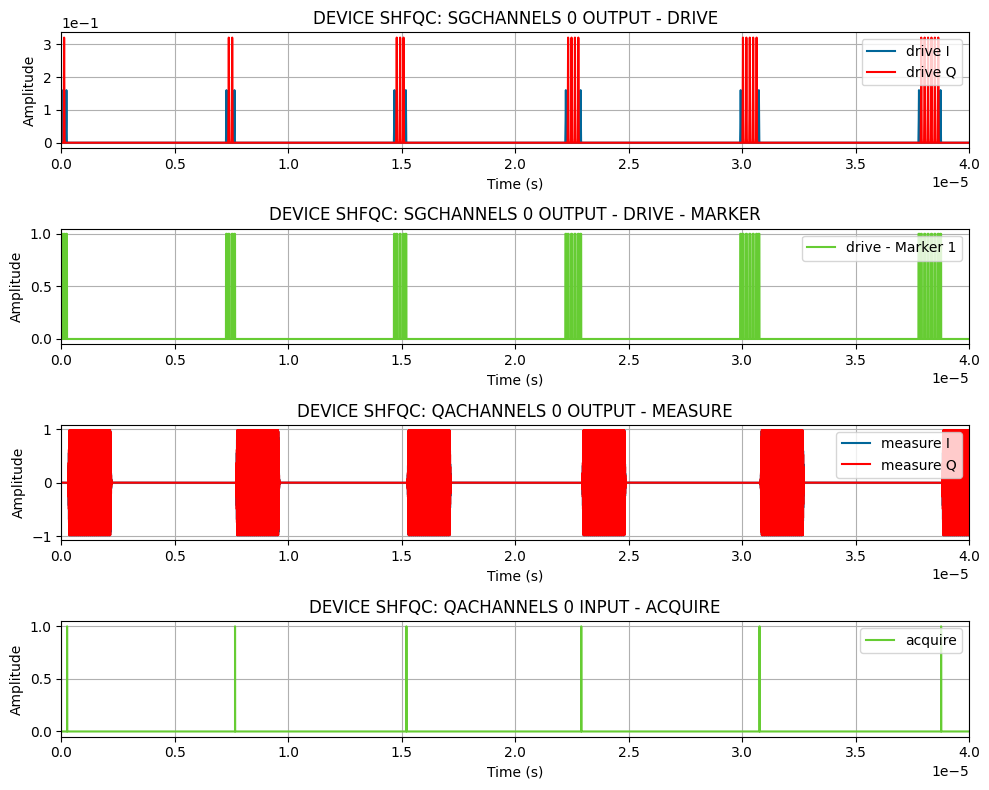

In [85]:
plot_simulation(compiled_cpmg, 00e-6, 40e-6, plot_width=10)

#### 3.10.6 Run, Save, and Plot Results

In [86]:
# run the compiled experiemnt
cpmg_results = session.run()
timestamp = time.strftime("%Y%m%dT%H%M%S")
Path("Results").mkdir(parents=True, exist_ok=True)
session.save_results(f"Results/{timestamp}_cpmg_results.json")
print(f"File saved as Results/{timestamp}_cpmg_results.json")

[2023.11.30 15:25:21.173] INFO    Starting near-time execution...
[2023.11.30 15:25:21.239] INFO    Finished near-time execution.
File saved as Results/20231130T152521_cpmg_results.json


In [87]:
# get measurement data returned by the instruments
cpmg_res = cpmg_results.get_data("cpmg")

# define time axis from qubit parameters
cpmg_pulses = cpmg_results.get_axis("cpmg")[0]+1


In [90]:
# plot measurement results
fig = plt.figure()
plt.plot(cpmg_pulses, cpmg_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Num pulses (N)")

# increase number of plot points for smooth plotting of fit results
cpmg_plot = np.linspace(cpmg_pulses[0], cpmg_pulses[-1], 5 * len(cpmg_pulses))

## fit measurement data to decaying sinusoidal oscillatio
popt, pcov = oscillatory_decay.fit(
    cpmg_pulses,
    cpmg_res,
    1e6,
    0,
    2 / 1 / 10e-6,
    0.5,
    0.5,
    plot=False,
    bounds=[
        [0.01e6, -np.pi / 2, 0.1 / 1 / 10e-6, 0.2, 0.2],
        [15e6, np.pi / 2, 10 / 1 / 10e-6, 2, 2],
    ],
)
print(f"Fitted parameters: {popt}")

# plot fit results together with experimental data
plt.plot(cpmg_plot, oscillatory_decay(cpmg_plot, *popt), "-r");

Fitted parameters: [1.00000000e+06 0.00000000e+00 2.00000000e+05 5.00000000e-01
 1.99998808e+00]


Text(0.5, 0, 'Num pulses (N)')

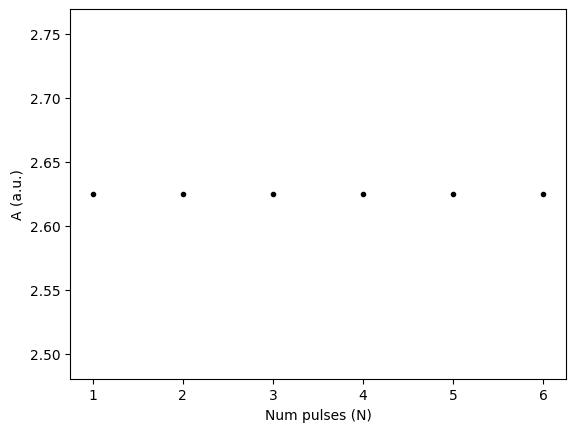

In [91]:
plt.plot(cpmg_pulses, cpmg_res, ".k")
plt.ylabel("A (a.u.)")
plt.xlabel("Num pulses (N)")